In [1]:
import pandas as pd
import numpy as np
import re
from functools import reduce

import seaborn as sns
from matplotlib import pyplot as plt
import textwrap

from sklearn.model_selection import train_test_split

pd.options.display.max_columns=None
pd.options.display.max_colwidth=310
pd.options.mode.chained_assignment=None

In [2]:
# Dataset completo procesado
ruta='data/formacion_procesado.csv'
df=pd.read_csv(ruta,index_col=0,low_memory=False)

# Naive decision tree

**Clasificador de ocupaciones a partir de títulos al estilo de un arbol de decisión**, con la diferencia de que, en lugar de identificar el punto de corte más explicativo en cada etapa, este clasificador solo reparte en ramas una vez y crea **tantas ramas como títulos distintos** haya en el dataset de entrenamiento.   

Para cada título identifica todas las ocupaciones, las ordena de más a menos frecuentes y  selecciona como predicción las ocupaciones en el **top n del ranking de frecuencias** que, además, estén por encima de un **umbral de frecuencia relativa establecido como mínimo**.   

Para cada título, este clasificador devuelve como **predicción una lista de ocupaciones ordenadas** de más a menos probables y las **probabilidades asociadas** a cada ocupación.   

## Parámetros del modelo

Los parámetros de este modelo son n, el **número máximo de posiciones en el ranking de ocupaciones** que se seleccionan como predictores, y el **umbral de frecuencia mínima**.   

El número de ocupaciones en la predicción para cada título puede ser mayor o menor que  n, el número de posiciones en el ranking de frecuencias que se tienen en cuenta:   

- Si alguna ocupación en el top n del ranking tiene una frecuencia inferior al umbral, se descarta como predictor. Así, es posible que la lista de ocupaciones seleccionadas tenga menos de n elementos.  

- Cuando hay empates entre ocupaciones en el top n de frecuencias, se incluyen en la predicción todas las que pertenecen al grupo empatado. Esto hace posible que se seleccionen más de n ocupaciones como predicción. 

## Entrenamiento, validación y test

En las **etapas iniciales** del proceso de construcción del clasificador se han empleado los datos de la **encuesta completa**. Se ha hecho así porque las primeras etapas son un **análisis descriptivo** del dataset que informa de las frecuencias de títulos y ocupaciones y de la distribución de las de ocupaciones distintas asociadas a cada título. Al aplicar el análisis sobre los datos de la encuesta completa obtenemos información poblacional sobre estas relaciones.   
  
Para las fases de entrenamiento y predicción se ha separado el dataset en tres subconjuntos: **train, validación y test**.    
  
El conjunto de **train** se obtiene como resultado de un **muestreo aleatorio estratificado** que garantiza una presencia de todos los títulos proporcional a la observada en la encuesta. No obstante, se han realizado pruebas sobre un conjunto de train seleccionado aleatoriamente sin estratificación. Los resultados de estas pruebas no difieren dramáticamente de los obtenidos con muestreo estratificado.   
  
Para la selección de los subconjuntos de **validación** y de **test** se ha buscado un **muestreo aleatorio no estratificado** para evitar que la similitud excesiva de las distribuciones de títulos en los tres conjuntos influya en la medición de la capacidad predictiva del clasificador. 

Las **proporciones** del tamaño de la encuesta que representan las observaciones seleccionadas en train, validación y test se fijan en 0.6, 0.2 y 0.2 respectivamente. 

El funcionamiento del algoritmo y el diseño de las métricas de evaluación se han ilustrado empleando las **columnas de título y de ocupacion literales** (strings) en lugar de las nuḿericas. Se ha decidido así porque facilita el hacerse una idea de cuáles son las titulaciones para las que es más o menos probable hacer predicciones acertadas durante el proceso de construcción del clasificador. No obstante, el diseño del algoritmo permite sutituir las columnas literales por las numéricas para operar de forma más eficiente. También permite establecer otros regresores y targets distintos de los títulos y las ocupaciones. 


## Objetivos del modelo

El principal objetivo de la construcción de un clasificador elemental es **conocer en qué medida las titulaciones universitarias de grado y de máster explican por sí solas las profesiones que alcanzan los titulados**.    
  
Se espera un éxito modesto por varios motivos:   

- Los títulos universitarios no son el único critero de los empleadores para seleccionar a su plantilla. Por un lado, un título universitario suele ser insuficiente por sí solo para aspirar a un buen número de puestos de trabajo reservados a universitarios. Por otro lado, a menudo los candidatos a un empleo pueden suplir la falta de un título universitario especializado con otros méritos, como la experiencia profesional o la formación en disciplinas afines. Los estudios de medicina son una excepción clara a esta posibilidad; los resultados constatan que las profesiones sanitarias están reservadas a titulados con formación especializada (aunque no todos los que tienen esa formación trabajan en ocupaciones relacionadas con su título). 


- Las encuestas empleadas en este proyecto solo informan con detalle de un **único título universitario de cada encuestado**. Aquellos que han accedido a su profesión gracias a un título distinto del que les hace elegibles para la encuesta en la que participan (otro grado, otro máster, un título de doctor) se escapan a la capacidad predictiva de los modelos basados en estos datos.  Esto se notará especialmente en los casos en los que el encuestado responde sobre un título que ha estudiado por motivos distintos a búsqueda de empleo o la promoción profesional mientras trabajaban en ocupaciones a las que accedieron gracias a una titulación previa.  


- El mal funcionamiento del mercado de trabajo español empuja a muchos aspirantes a un empleo a aceptar trabajos poco o nada relacionados con su formación y sus conocimientos.   

Los resultados del modelo sirven también al objetivo de **identificar las titulaciones que tienen relaciones más estrechas con las ocupaciones** más frecuentes de los titulados y aquellas otras para las cuales la capacidad del título como predicctor de la profesión futura es más pobre. 


## Justificación

**Ventajas de la construcción del algoritmo a medida** (en lugar de emplear una solución estándar):  

- **Simplicidad** de la justificación teórica que sustenta las predicciones. Facilita la interpretación de los resultados.  
  
  
- Clasificador **específico** para un modelo con un **único regresor** en el que, además, **el regresor y el target son variables categóricas**.  


- **Flexibilidad** para definir los criterios de agregación de las métricas de evaluación, por titulaciones (o categorías del regresor) o por ocupaciones (categorías del target). En particular, emplear un único regresor permite obtener mediciones del accuracy desagregadas para cada uno de los títulos observados en el proceso de evaluación. Esto facilita la identificación de los títulos y las profesiones para las que es más y menos probable hacer predicciones acertadas.   
  
  
- **Flexibilidad** para incorporar un número variable de precicciones para cada título a las métricas de accuracy, recall y precisión y para ajustar estas métricas de acuerdo con las probabilidades asignadas a las distintas predicciones.  
   

- El proceso de construcción del algoritmo es, en su mayor parte, un **análisis descriptivo** de las relaciones entre titulaciones y ocupaciones. Este análisis se ha ilustrado y probado con los datos de la encuesta completa para **estimar la dificultad del problema de clasificación** (que se resuelve, más adelante, sobre subconjuntos de train, validación y test).  

# Dataset encuesta 

#### Observaciones con target informado

In [3]:
# Selección: solo ocupaciones informadas
df=df[df['ocupacion'].notna()]
df.shape

(59844, 356)

#### Número de categorías distintas del target: 

In [4]:
df['ocupacion'].nunique()
# Ocupaciones distintas (núm. categorías del target):

62

#### Número de categorías distintas del regresor: 

In [5]:
df['titulo_ppal_'].nunique()
# Titulos distintos (num. categorías del regresor principal): 

173

# 1. Distribución del número de ocupaciones distintas por título

### Regresor y target:
En adelante se identifican el título principal como regresor y la ocupación como target. Esto facilitará la generalización del clasificador naive a otros targets y regresores. 

In [6]:
def num_cat_targets_por_cat_regresor(data,regresor,target):
    
    """ Cuenta el número de categorías distintas del target para cada categoría del regresor
    """
    columnas=[regresor,target]
    out=data[columnas].groupby(regresor).agg(['nunique'])
    out.columns=out.columns.to_flat_index() 
    out.rename(columns={out.columns[-1]:'num categorias target para regresor'},inplace=True)
    out.sort_values(by='num categorias target para regresor',inplace=True)
    out.reset_index(inplace=True)
    
    return out

In [7]:
num_oc_por_titulo_encuesta=num_cat_targets_por_cat_regresor(data=df,regresor='titulo_ppal_',target='ocupacion_')
num_oc_por_titulo_encuesta.head(10)

,titulo_ppal_,num categorias target para regresor
0,Grado Odontología,5
1,Máster Odontología,6
2,"Máster Ciencias químicas, físicas y geológicas; Matemáticas y estadística (Otros estudios)",8
3,Máster Religión y teología,9
4,Máster Lenguas (Otros estudios),10
5,Grado Medicina,10
6,Máster Veterinaria,10
7,Grado Protocolo y eventos,11
8,Máster Estadística,11
9,Máster Enfermería,11


In [8]:
num_oc_por_titulo_encuesta.tail(10)

,titulo_ppal_,num categorias target para regresor
163,"Grado Ingeniería agrícola, agropecuaria y medio rural",50
164,Grado Actividad física y del deporte,50
165,Grado Trabajo social,51
166,Grado Educación infantil,52
167,Grado Ciencias ambientales,52
168,Grado Educación primaria,52
169,Grado Economía,53
170,Grado Historia,53
171,Grado Arquitectura técnica,53
172,Grado Administración y empresa,54


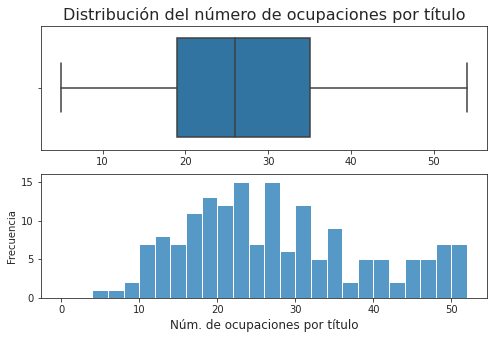

In [9]:
sns.set_style('ticks')

fig, [ax1, ax2] = plt.subplots(2, 1,figsize=(8,5))
font_titles=16
font_labels=12

sns.boxplot(ax=ax1,data=num_oc_por_titulo_encuesta,
            x='num categorias target para regresor')
ax1.set_title('Distribución del número de ocupaciones por título',fontsize=font_titles) 
ax1.set_xlabel('',fontsize=font_labels)

max_num_oc=num_oc_por_titulo_encuesta['num categorias target para regresor'].max()

sns.histplot(ax=ax2,data=num_oc_por_titulo_encuesta,
             x='num categorias target para regresor',
             bins=np.arange(0,max_num_oc,2))

ax2.set_xlabel('Núm. de ocupaciones por título',fontsize=font_labels)
ax2.set_ylabel('Frecuencia',fontsize=font_labels-2)
ax2.set_ylim(0,16)

fig.subplots_adjust(hspace=.2)
plt.show()

## 1.1. Número de ocupaciones distintas por título: resumen 

In [10]:
# Distribución del número de ocupaciones por título: resumen
ocupaciones_tt=pd.DataFrame(num_oc_por_titulo_encuesta['num categorias target para regresor'].describe())
ocupaciones_tt.rename(columns={'num categorias target para regresor':
                               'Distribución núm. de ocupaciones distintas por título'},inplace=True)
ocupaciones_tt

,Distribución núm. de ocupaciones distintas por título
count,173.000000
mean,27.705202
std,12.290563
min,5.000000
25%,19.000000
50%,26.000000
75%,35.000000
max,54.000000


## 1.2. Número de ocupaciones distintas por rama de conocimento

Exploración de la distribución del número de ocupaciones distintas para cada título para los títulos agregados por ramas de conocimiento.

In [11]:
# df auxiliar para añadir ramas de conocimiento a la distribución de número de ocupaciones por título:
df_ramas=df[['titulo_ppal_','rama_ppal_']].drop_duplicates()
df_ramas.head()

,titulo_ppal_,rama_ppal_
0,Grado Pedagogía,Ciencias sociales y jurídicas
568,Grado Educación infantil,Ciencias sociales y jurídicas
1933,Grado Educación primaria,Ciencias sociales y jurídicas
3840,Grado Otros maestros,Ciencias sociales y jurídicas
4007,Grado Educación social,Ciencias sociales y jurídicas


In [12]:
# df auxiliar para añadir ramas de conocimiento a la distribución de número de ocupaciones por título:
num_oc_por_titulo_ramas=num_oc_por_titulo_encuesta.merge(df_ramas,on='titulo_ppal_',how='left')

# Orden de acuerdo con mediana y mínimo de núm. categorías target para regresor para boxplot:
aux_ordena=num_oc_por_titulo_ramas[['rama_ppal_','num categorias target para regresor']]\
                    .groupby('rama_ppal_').agg(['median','min'])
aux_ordena.columns=aux_ordena.columns.to_flat_index()
aux_ordena.rename(columns=({aux_ordena.columns[-2]:'mediana'}),inplace=True)
aux_ordena.rename(columns=({aux_ordena.columns[-1]:'min'}),inplace=True)

num_oc_por_titulo_ramas=num_oc_por_titulo_ramas.merge(aux_ordena,on='rama_ppal_',how='left')
num_oc_por_titulo_ramas.sort_values(by=['mediana','min'],inplace=True)
num_oc_por_titulo_ramas.head()

,titulo_ppal_,num categorias target para regresor,rama_ppal_,mediana,min
0,Grado Odontología,5,Ciencias de la salud,19,5
1,Máster Odontología,6,Ciencias de la salud,19,5
5,Grado Medicina,10,Ciencias de la salud,19,5
6,Máster Veterinaria,10,Ciencias de la salud,19,5
9,Máster Enfermería,11,Ciencias de la salud,19,5


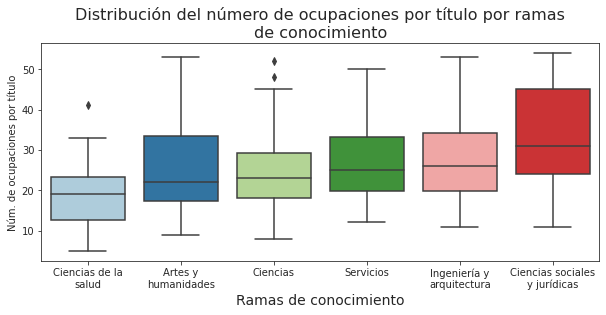

In [13]:
fig, ax = plt.subplots(1, 1,figsize=(10,4))
font_titles=16
font_labels=14

ax = sns.boxplot(data=num_oc_por_titulo_ramas, 
                 x='rama_ppal_',
                 y='num categorias target para regresor',
                 palette='Paired')

titulo='Distribución del número de ocupaciones por título por ramas de conocimiento'
ax.set_title(textwrap.fill(titulo,60), fontsize=font_titles)
ax.set_xlabel('Ramas de conocimiento',fontsize=font_labels)
ax.set_ylabel('Núm. de ocupaciones por título')
ax.set_xticklabels(textwrap.fill(tick.get_text(),18) for tick in ax.get_xticklabels())

plt.show()

## 1.3. Número de ocupaciones distintas por familia de estudios

Exploración del número de ocupaciones distintas por título para los títulos agregados por familias de estudios. 

In [14]:
# df auxiliar para añadir familias de estudios a la distribución de número de ocupaciones por título:
df_familias=df[['titulo_ppal_','familia_ppal_']].drop_duplicates()
df_familias.head()

,titulo_ppal_,familia_ppal_
0,Grado Pedagogía,Educación
568,Grado Educación infantil,Educación
1933,Grado Educación primaria,Educación
3840,Grado Otros maestros,Educación
4007,Grado Educación social,Educación


In [15]:
# df auxiliar para añadir familias de estudios a la distribución de número de ocupaciones por título:
num_oc_por_titulo_familias=num_oc_por_titulo_encuesta.merge(df_familias,on='titulo_ppal_',how='left')

# Orden de acuerdo con mediana de núm. categorías target para regresor:
aux_ordena=num_oc_por_titulo_familias[['familia_ppal_','num categorias target para regresor']]\
                    .groupby('familia_ppal_').agg(['median'])
aux_ordena.columns=aux_ordena.columns.to_flat_index()
aux_ordena.rename(columns=({aux_ordena.columns[-1]:'mediana'}),inplace=True)

num_oc_por_titulo_familias=num_oc_por_titulo_familias.merge(aux_ordena,on='familia_ppal_',how='left')
num_oc_por_titulo_familias.sort_values(by='mediana',inplace=True)
num_oc_por_titulo_familias.head()

,titulo_ppal_,num categorias target para regresor,familia_ppal_,mediana
162,Grado Informática,50,Informática,16.0
31,Máster Diseño y administración de bases de datos y redes,16,Informática,16.0
32,Máster Tecnologías de la información y las comunicaciones (Otros estudios),16,Informática,16.0
11,Grado Desarrollo de software y de aplicaciones e Ingeniería multimedia,12,Informática,16.0
60,Máster Desarrollo y análisis de aplicaciones y de software,21,Informática,16.0


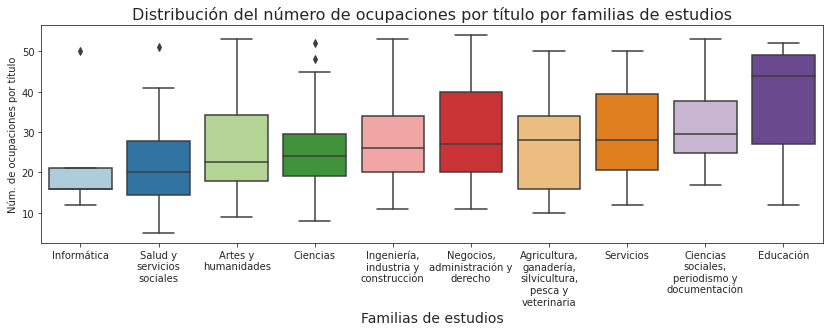

In [16]:
fig, ax = plt.subplots(1, 1,figsize=(14,4))
font_titles=16
font_labels=14

ax = sns.boxplot(data=num_oc_por_titulo_familias, 
                 x='familia_ppal_',\
                 y='num categorias target para regresor',
                 palette='Paired')

ax.set_title('Distribución del número de ocupaciones por título por familias de estudios',fontsize=font_titles)
ax.set_ylabel('Núm. de ocupaciones por título')
ax.set_xlabel('Familias de estudios',fontsize=font_labels)
ax.set_xticklabels(textwrap.fill(tick.get_text(),16) for tick in ax.get_xticklabels())

plt.show()

### Observación: 

El número de ocupaciones observadas y el número de encuestados para cada título tienen una relación directa. Esta relación es más intensa cuanto menor es el número de titulados encuestados.  

Por ejemplo, en el caso de la familia de estudios de Informática, solo hay un título con más de 500 encuestados, el grado en Informática, para el que se observan 50 ocupaciones distintas, lo que le situa como un valor extremo en el gráfico de cajas y bigotes de su familia de estudios.  

A continuación se explora la relación entre el número de encuestados y el número de ocupaciones con más detalle. 

# 2. Número de titulados (observaciones) por título

Se explora la relación entre el número de encuestados (o titulados) y el número de ocupaciones distintas observadas para cada título. 

In [17]:
def num_obs_por_cat_regresor(data,regresor,target):
    
    """ Cuenta el número de categorías del target y el número de observaciones para cada categoría del regresor. 
    """
    
    columnas=[regresor,target]
    out=data[columnas].groupby([regresor]).agg(['count'])
    out.columns=out.columns.to_flat_index()
    out.reset_index(inplace=True)
    out.rename(columns={out.columns[-1]:'obs regresor'},inplace=True)
    
    previo=num_cat_targets_por_cat_regresor(data=data,regresor=regresor,target=target)
    out=out.merge(previo,on=regresor,how='outer')
    out=out.sort_values(by='num categorias target para regresor')
    out.reset_index(drop=True,inplace=True)
    
    return out

In [18]:
num_titulados_encuesta=num_obs_por_cat_regresor(data=df,regresor='titulo_ppal_',target='ocupacion_')
num_titulados_encuesta.head()

,titulo_ppal_,obs regresor,num categorias target para regresor
0,Grado Odontología,243,5
1,Máster Odontología,73,6
2,"Máster Ciencias químicas, físicas y geológicas; Matemáticas y estadística (Otros estudios)",31,8
3,Máster Religión y teología,25,9
4,Máster Lenguas (Otros estudios),53,10


In [19]:
num_titulados_encuesta.tail()

,titulo_ppal_,obs regresor,num categorias target para regresor
168,Grado Educación primaria,2065,52
169,Grado Economía,1174,53
170,Grado Historia,697,53
171,Grado Arquitectura técnica,1050,53
172,Grado Administración y empresa,2637,54


## 2.1. Número de titulados por título: resumen 

In [20]:
# Distribución del número de encuestados (o titulados) por titulo: resumen
encuestados_tt=pd.DataFrame(num_titulados_encuesta['obs regresor'].describe())
encuestados_tt.rename(columns={'obs regresor':'Distribución núm. de encuestados por título'},inplace=True)
encuestados_tt

,Distribución núm. de encuestados por título
count,173.000000
mean,345.919075
std,477.144211
min,23.000000
25%,90.000000
50%,154.000000
75%,355.000000
max,2637.000000


## 2.2. Número de titulados y número de ocupaciones por título

In [21]:
# df auxiliar: se añaden columnas para la rama de conocimiento y para la familia de estudios de cada título: 
num_titulados_encuesta=num_titulados_encuesta.merge(df_ramas,on='titulo_ppal_',how='left')
num_titulados_encuesta=num_titulados_encuesta.merge(df_familias,on=['titulo_ppal_'],how='left')
num_titulados_encuesta.head()

,titulo_ppal_,obs regresor,num categorias target para regresor,rama_ppal_,familia_ppal_
0,Grado Odontología,243,5,Ciencias de la salud,Salud y servicios sociales
1,Máster Odontología,73,6,Ciencias de la salud,Salud y servicios sociales
2,"Máster Ciencias químicas, físicas y geológicas; Matemáticas y estadística (Otros estudios)",31,8,Ciencias,Ciencias
3,Máster Religión y teología,25,9,Artes y humanidades,Artes y humanidades
4,Máster Lenguas (Otros estudios),53,10,Artes y humanidades,Artes y humanidades


In [22]:
# Columna auxiliar para ordenar boxplot por mediana y mínimo del número de ocupaciones distintas: 
num_titulados_encuesta.rename(columns={'num categorias target para regresor':'num cat'},inplace=True)
aux_mediana_cat=num_titulados_encuesta[['rama_ppal_','num cat']].groupby('rama_ppal_').agg(['median'])
aux_mediana_cat.columns=aux_mediana_cat.columns.to_flat_index()
aux_mediana_cat.rename(columns={aux_mediana_cat.columns[-1]:'mediana cat'},inplace=True)
aux_mediana_cat.sort_values(by='mediana cat')

num_titulados_encuesta=num_titulados_encuesta.merge(aux_mediana_cat,on='rama_ppal_',how='left')

num_titulados_encuesta.sort_values(by='mediana cat',inplace=True)
#num_titulados_encuesta

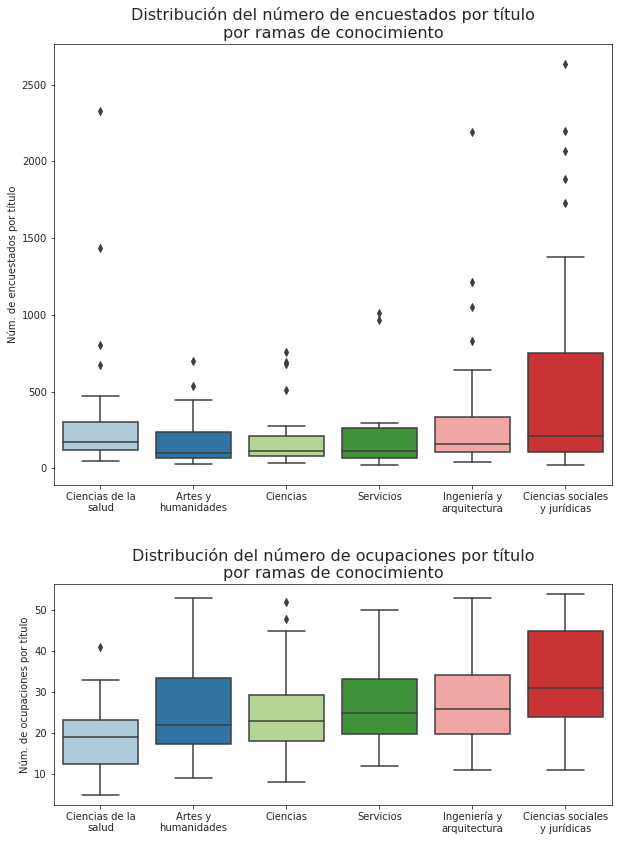

In [23]:
from matplotlib import gridspec

fig= plt.figure(figsize=(10, 14)) 
gs = gridspec.GridSpec(2, 1, height_ratios=[4, 2]) 

cols=['obs regresor','num cat']

for i,col in enumerate(cols):

    ax=plt.subplot(gs[i])
    sns.boxplot(data=num_titulados_encuesta, 
                     x='rama_ppal_',
                     y=col,
                     palette='Paired')

    titulos=['Distribución del número de encuestados por título por ramas de conocimiento',
             'Distribución del número de ocupaciones por título por ramas de conocimiento']
    y_labels=['Núm. de encuestados por título', 'Núm. de ocupaciones por título']
    ax.set_title(textwrap.fill(titulos[i],50), fontsize=16)
    ax.set_xlabel('')
    ax.set_ylabel(y_labels[i])
    ax.set_xticklabels(textwrap.fill(tick.get_text(),18) for tick in ax.get_xticklabels())

fig.subplots_adjust(hspace=0.3)
plt.show()

### Observación: 

Los gráficos de cajas y bigotes del número de titulados y el número de ocupaciones para cada título agrupados por ramas de conocimiento sugiere una relación directa entre encuestados y ocupaciones observadas excepto para la rama de Ciencias de la salud. Para el resto de ramas se observa que la mediana del número de ocupaciones crece con la mediana del número de encuestados. También se aprecia que esta relación no tiene la misma intensidad para todas las ramas de conocimiento.  

Para explorar esta relación, se representa a continuación el número de encuestados y de ocupaciones para cada título y se analizan los resultados para cada familia de estudios. 

In [24]:
# Columnas auxiliares para plot por familias de estudios: 
aux_dumm_familias=pd.get_dummies(data=num_titulados_encuesta,columns=['familia_ppal_'],
                                 prefix='Familia',prefix_sep=' ')
#aux_dumm_familias.head()

In [25]:
# Títulos abreviados:
D_titulos_abreviados={'Máster Formación de docentes de educación secundaria y formación profesional':
                     'Máster Formación docentes ES y FP'}
aux_dumm_familias['titulo_ppal_'].replace(D_titulos_abreviados,inplace=True)
#aux_dumm_familias

In [26]:
# Coordenadas de títulos con más de un número mínimo de encuestados min_obs: 
lista_familias=num_titulados_encuesta['familia_ppal_'].unique().tolist()

min_obs=500 

puntos=list()
for familia in lista_familias:
    aux_tts=aux_dumm_familias[aux_dumm_familias['Familia '+familia]==1]
    aux_tts=aux_tts[aux_tts['obs regresor']>min_obs]
    puntos.append(list(zip(aux_tts['obs regresor'],aux_tts['num cat'],aux_tts['titulo_ppal_'])))  
#puntos

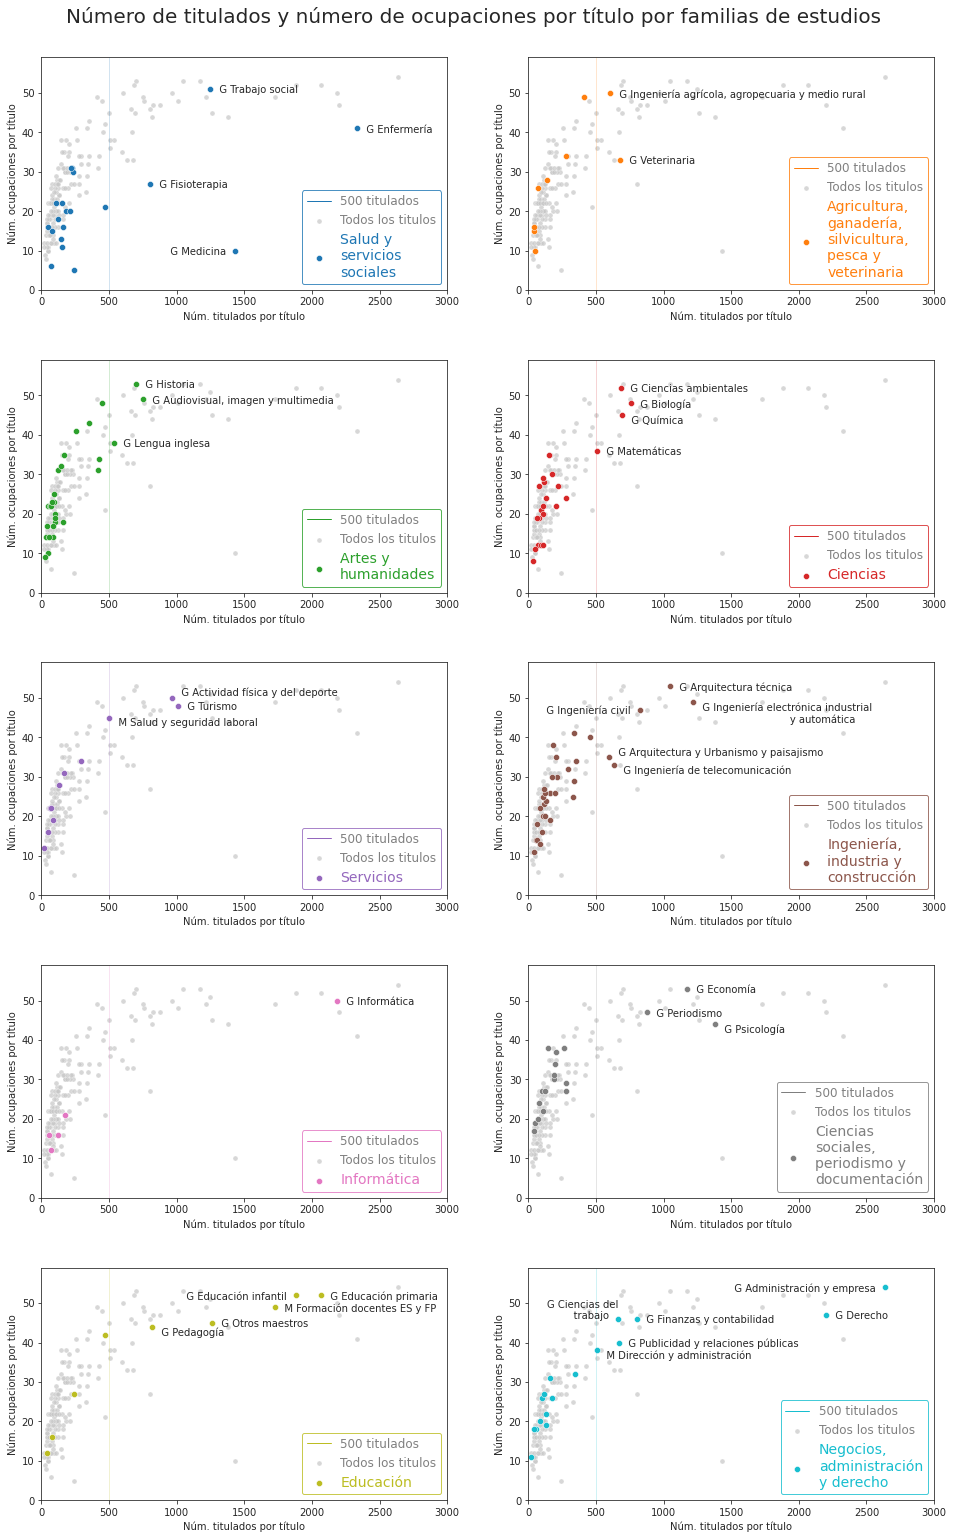

In [27]:
sns.set_style('ticks')

paleta=sns.color_palette('tab20')

criterio='familia_ppal_'

fig, axes = plt.subplots(5, 2,figsize=(16,24))
font_titles=20
font_labels=10

titulo_1='Número de titulados y número de ocupaciones por título por familias de estudios'
fig.suptitle(titulo_1,fontsize=font_titles,va='baseline')

for i,clase in enumerate(num_titulados_encuesta[criterio].unique()):
    
    dummy='Familia '+clase
    data=aux_dumm_familias[['obs regresor','num cat',dummy]]
    
    # Coordenadas de cada gráfico en axes: 
    a1=i//2 
    a2=i%2 

    sns.scatterplot(ax=axes[a1,a2],data=data,
                x='obs regresor',
                y='num cat',
                color=paleta.as_hex()[15],alpha=0.7,s=25) # todos los títulos
    
    sns.scatterplot(ax=axes[a1,a2],data=data[data[dummy]==1],
                x='obs regresor',
                y='num cat',
                color=paleta.as_hex()[i*2],s=37) # familia
    
    sns.lineplot(ax=axes[a1,a2],
                x=np.array([min_obs]*2),
                y=np.array([0,59]),
                color=paleta.as_hex()[i*2], linewidth=1) # recta x=min_obs
    
    # Titulos con más de 500 encuestados: 
    for tt in puntos[lista_familias.index(clase)]: 
        texto='   '+tt[2].split(' ',1)[0][0]+' '+tt[2].split(' ',1)[1]
        # Ajustes posición: 
        if tt[2] in ['Grado Medicina','Grado Administración y empresa','Grado Ingeniería civil',
                     'Grado Educación infantil'] :
            texto=texto+'   '
            axes[a1,a2].text(x=tt[0], y=tt[1], s=texto,va='center_baseline',ha='right')
        elif tt[2] in ['Grado Química','Grado Pedagogía','Máster Salud y seguridad laboral',
                      'Grado Ingeniería de telecomunicación','Grado Psicología',
                       'Máster Dirección y administración']:
            texto=texto+'   '
            axes[a1,a2].text(x=tt[0], y=tt[1], s=texto,va='top')    
        elif tt[2] in ['Grado Actividad física y del deporte','Grado Arquitectura y Urbanismo y paisajismo']:
            texto=texto+'   '
            axes[a1,a2].text(x=tt[0], y=tt[1], s=texto,va='bottom')
        elif tt[2]=='Grado Ingeniería electrónica industrial y automática':
            texto='   G Ingeniería electrónica industrial\n                               y automática'
            axes[a1,a2].text(x=tt[0], y=tt[1], s=texto,va='top')
        elif tt[2]=='Grado Ciencias del trabajo':
            texto='G Ciencias del\n     trabajo   '
            axes[a1,a2].text(x=tt[0], y=tt[1], s=texto,ha='right')
        else:
            axes[a1,a2].text(x=tt[0], y=tt[1], s=texto,va='center_baseline')
    
    axes[a1,a2].set_xlabel('Núm. titulados por título',fontsize=font_labels)
    axes[a1,a2].set_ylabel('Núm. ocupaciones por título',fontsize=font_labels)
    axes[a1,a2].set_xlim(0,3000)
    axes[a1,a2].set_ylim(0,59)
    
    leyenda=axes[a1,a2].legend([str(min_obs)+' titulados','Todos los titulos',textwrap.fill(clase,15)],
                               loc='lower right',fontsize='large',edgecolor=paleta.as_hex()[i*2])
    for color,text in zip(['grey','grey',paleta.as_hex()[i*2]],leyenda.get_texts()):
        text.set_color(color)
    for size,text in zip([12,12,14],leyenda.get_texts()):
        text.set_size(size)
        
fig.subplots_adjust(hspace=0.3)
fig.subplots_adjust(top=0.96)
plt.show()

### Observaciones: 

- Se constata una **relación directa entre el número de encuestados (o titulados) y el número de ocupaciones distintas observadas para cada titulo**.  
    
    
- Esta relación es **más intensa cuanto menor es el número de encuestados**: para los títulos con solo unos pocos cientos de encuestados, el número de categorías observadas es casi proporcional al número de titulados consultados. Sin embargo, cuando el número de encuestados es suficientemente alto, el número de ocupaciones se estabiliza. En otras palabras, llega un momento en el que no por preguntar a más titulados se obtienen más respuestas diferentes sobre sus ocupaciones.   
  
  
- El análisis del **coeficiente de correlación lineal** del número de encuestados y el número de ocupaciones confirma esta conclusión: el coeficiente de correlación ronda el valor 0.7 cuando se calcula para toda la muestra, desciende hasta 0.24 cuando se excluyen las titulaciones con menos de 500 encuestados y se reduce hasta 0.1 cuando solo se tienen en cuenta los títulos con más de 1000 encuestados (véanse los resultados exactos a continuación).  
   
   
- El **grado en Medicina** es una excepción a esta regla: a pesar de tener un número de encuestados muy superior al tercer cuartil, el número de ocupaciones observadas para el título es muy inferior al primer cuartil de la distribución del número de ocupaciones distintas (véanse los valores exactos a continuación).  

In [28]:
# Correlación número de encuestados y núm. de ocupaciones: muestra completa
num_titulados_encuesta[['obs regresor', 'num cat']].corr()

,obs regresor,num cat
obs regresor,1.000000,0.695259
num cat,0.695259,1.000000


In [29]:
# Correlación número de encuestados y núm. de ocupaciones: títulos con más de 500 encuestados: 
num_titulados_encuesta[['obs regresor', 'num cat']][num_titulados_encuesta['obs regresor']>500].corr()

,obs regresor,num cat
obs regresor,1.000000,0.239282
num cat,0.239282,1.000000


In [30]:
# Correlación número de encuestados y núm. de ocupaciones: títulos con más de 1000 encuestados
num_titulados_encuesta[['obs regresor', 'num cat']][num_titulados_encuesta['obs regresor']>1000].corr()

,obs regresor,num cat
obs regresor,1.000000,0.099846
num cat,0.099846,1.000000


In [31]:
# Exploración grado en Medicina: excepción a la relación directa entre núm. encuestados y núm. de ocupaciones
distribuciones_tt=encuestados_tt.merge(ocupaciones_tt,left_index=True,right_index=True)
medicina_encuestados=int(aux_dumm_familias[aux_dumm_familias['titulo_ppal_']=='Grado Medicina']['obs regresor'])
medicina_ocupaciones=int(aux_dumm_familias[aux_dumm_familias['titulo_ppal_']=='Grado Medicina']['num cat'])
distribuciones_tt.loc['Grado Medicina','Distribución núm. de encuestados por título']=medicina_encuestados
distribuciones_tt['Distribución núm. de ocupaciones distintas por título'].loc['Grado Medicina']\
                 =medicina_ocupaciones
distribuciones_tt

,Distribución núm. de encuestados por título,Distribución núm. de ocupaciones distintas por título
count,173.000000,173.000000
mean,345.919075,27.705202
std,477.144211,12.290563
min,23.000000,5.000000
25%,90.000000,19.000000
50%,154.000000,26.000000
75%,355.000000,35.000000
max,2637.000000,54.000000
Grado Medicina,1433.000000,10.000000


# 3. Número de profesionales por título y ocupación

El clasificador de ocupaciones a partir de los títulos universitarios selecciona como predicción para cada título las ocupaciones más frecuentes de sus titulados. 

A continuación se cuenta, para cada título, el número de profesionales de cada ocupación. Esto permite calcular la frecuencia relativa de cada ocupación para cada título y la frecuencia relativa acumulada asociada a una ordenación decreciente de las frecuencias relativas, también título a título. 

In [32]:
def num_cat_target_por_regresor_y_target(data,regresor,target):
    
    """Cuenta, para cada cagegoría del regresor, el número de observaciones, el número de categorías distintas
    del target y el número de observaciones de cada categoría del target. 
    """
    
    columnas=[regresor,target]
    out=data[columnas].groupby(regresor).agg(['value_counts'])
    out.columns=out.columns.to_flat_index()
    out.reset_index(inplace=True)
    out.rename(columns={out.columns[-1]:'obs target'},inplace=True)
    
    previo=num_obs_por_cat_regresor(data=data,regresor=regresor,target=target)
    out=previo.merge(out,on=regresor,how='outer')
    out.sort_values(by=['num categorias target para regresor','obs target'],ascending=[True,False],inplace=True)
    
    return out

In [33]:
prof_por_oc_y_titulo_encuesta=num_cat_target_por_regresor_y_target(data=df,
                                                                   regresor='titulo_ppal_',target='ocupacion_')
prof_por_oc_y_titulo_encuesta.head()

,titulo_ppal_,obs regresor,num categorias target para regresor,ocupacion_,obs target
0,Grado Odontología,243,5,Prof sanitarios,237
1,Grado Odontología,243,5,Gerentes en servicios excepto hostelería y comercio,2
2,Grado Odontología,243,5,Prof enseñanza,2
3,Grado Odontología,243,5,Directores producción y operaciones,1
4,Grado Odontología,243,5,Trabajadores servicios de cuidados de salud,1


In [34]:
prof_por_oc_y_titulo_encuesta.tail()

,titulo_ppal_,obs regresor,num categorias target para regresor,ocupacion_,obs target
4788,Grado Administración y empresa,2637,54,Montadores y ensambladores en fábricas,1
4789,Grado Administración y empresa,2637,54,Peones de construcción y minería,1
4790,Grado Administración y empresa,2637,54,Trabajadores construcción e instalaciones: acabado,1
4791,Grado Administración y empresa,2637,54,Trabajadores construcción y afines: estructura,1
4792,Grado Administración y empresa,2637,54,Trabajadores servicios de cuidados no de salud,1


## 3.1. Proporción de profesionales sobre titulados por ocupación y título

Se calculan las frecuencias relativas y frecuencias relativas acumuadas de las ocupaciones para cada título. Para calcular las frecuencias acumuladas se ordenan las ocupaciones observadas para cada título por frecuencia relativa en orden descendente. 

In [35]:
def frecuencias_cat_target_por_regresor(data,regresor,target):
    
    """Calcula la frecuencia relativa con la que se observa cada categoría del target asociada a cada categoría 
    del regresor como proporción del número de observaciones de cada combinación de categoría de regresor y de 
    target sobre el número de observaciones de la categoría del regresor. 
    Y calcula las frecuencias relativas acumuladas (o proporciones acumuladas) para las ocupaciones asociadas a 
    la misma categoría ordenadas de mayor a menor de acuerdo con su frecuencia relativa.
    """
    
    previo=num_cat_target_por_regresor_y_target(data=data,regresor=regresor,target=target)
    # 'prop' = proporción de obs. del target sobre núm. obs. para la categoría del regresor: 
    previo['prop']=previo['obs target'].div(previo['obs regresor'])
    
    # Frecuencias acumuladas: 
    acum=previo[[regresor,'prop']].groupby(regresor).cumsum()
    acum.rename(columns={acum.columns[-1]:'prop acum'},inplace=True)
    
    out=previo.merge(acum,left_index=True,right_index=True,how='outer')
    
    
    return out

In [36]:
proporciones_encuesta=frecuencias_cat_target_por_regresor(data=df,regresor='titulo_ppal_',target='ocupacion_')
proporciones_encuesta.head()

,titulo_ppal_,obs regresor,num categorias target para regresor,ocupacion_,obs target,prop,prop acum
0,Grado Odontología,243,5,Prof sanitarios,237,0.975309,0.975309
1,Grado Odontología,243,5,Gerentes en servicios excepto hostelería y comercio,2,0.008230,0.983539
2,Grado Odontología,243,5,Prof enseñanza,2,0.008230,0.991770
3,Grado Odontología,243,5,Directores producción y operaciones,1,0.004115,0.995885
4,Grado Odontología,243,5,Trabajadores servicios de cuidados de salud,1,0.004115,1.000000


In [37]:
proporciones_encuesta.tail()

,titulo_ppal_,obs regresor,num categorias target para regresor,ocupacion_,obs target,prop,prop acum
4788,Grado Administración y empresa,2637,54,Montadores y ensambladores en fábricas,1,0.000379,0.998483
4789,Grado Administración y empresa,2637,54,Peones de construcción y minería,1,0.000379,0.998862
4790,Grado Administración y empresa,2637,54,Trabajadores construcción e instalaciones: acabado,1,0.000379,0.999242
4791,Grado Administración y empresa,2637,54,Trabajadores construcción y afines: estructura,1,0.000379,0.999621
4792,Grado Administración y empresa,2637,54,Trabajadores servicios de cuidados no de salud,1,0.000379,1.000000


## 3.2. Ranking de ocupaciones por título

Se ordenan las ocupaciones asociadas a cada título en un ranking de más a menos frecuentes. En caso de empate se asigna a todas las ocupaciones con el mismo número de observaciones la posición en el ranking mínima del conjunto empatado. 

In [38]:
def ranking_cat_target_por_cat_regresor(data,regresor,target):
    
    """Para cada categoría del regresor, identifica el ranking de ocupaciones ordenadas de más a menos frecuentes.
    Los empates se resuelven imputando a todas las categorías del target empatadas el valor mínimo de las 
    posiciones del grupo.
    """
    
    previo=frecuencias_cat_target_por_regresor(data=data,regresor=regresor,target=target)
    rank=previo[[regresor,'obs target']]
    rank=rank.groupby(regresor).rank(method='min',ascending=False)
    rank.rename(columns={rank.columns[-1]:'rank'},inplace=True)
    
    out=previo.merge(rank,how='outer',left_index=True,right_index=True)
    out.sort_values(by=['num categorias target para regresor','rank'],inplace=True)
    
    return out 

In [39]:
ranking_encuesta=ranking_cat_target_por_cat_regresor(data=df,regresor='titulo_ppal_',target='ocupacion_')
ranking_encuesta.head()

,titulo_ppal_,obs regresor,num categorias target para regresor,ocupacion_,obs target,prop,prop acum,rank
0,Grado Odontología,243,5,Prof sanitarios,237,0.975309,0.975309,1.0
1,Grado Odontología,243,5,Gerentes en servicios excepto hostelería y comercio,2,0.008230,0.983539,2.0
2,Grado Odontología,243,5,Prof enseñanza,2,0.008230,0.991770,2.0
3,Grado Odontología,243,5,Directores producción y operaciones,1,0.004115,0.995885,4.0
4,Grado Odontología,243,5,Trabajadores servicios de cuidados de salud,1,0.004115,1.000000,4.0


In [40]:
ranking_encuesta.tail()

,titulo_ppal_,obs regresor,num categorias target para regresor,ocupacion_,obs target,prop,prop acum,rank
4788,Grado Administración y empresa,2637,54,Montadores y ensambladores en fábricas,1,0.000379,0.998483,48.0
4789,Grado Administración y empresa,2637,54,Peones de construcción y minería,1,0.000379,0.998862,48.0
4790,Grado Administración y empresa,2637,54,Trabajadores construcción e instalaciones: acabado,1,0.000379,0.999242,48.0
4791,Grado Administración y empresa,2637,54,Trabajadores construcción y afines: estructura,1,0.000379,0.999621,48.0
4792,Grado Administración y empresa,2637,54,Trabajadores servicios de cuidados no de salud,1,0.000379,1.000000,48.0


# 4. Ranking de ocupaciones más frecuentes por título (clasificador naive) 

Se fija el **número de posiciones en el ranking de frecuencias relativas que se incluirán en la predicción** de ocupaciones para cada título. Este parámetro se denomina **max_rank**. 
 
El criterio elegido para resolver los empates implica que, cuando se estos se produzcan en posiciones inferiores al valor max_rank, todas las ocupaciones empatadas serán incluidas en la predicción. Esto puede causar que el número de ocupaciones predichas para algún título sea mayor que el parámetro max_rank. 

Se define también un **umbral mínimo de frecuencia relativa, min_prop**, para que una ocupación se incluya entre las predicciones para un título. 

Así, el número de predicciones para un título será inferior al parámetro max_rank cuando el número de ocupaciones distintas para ese título sea inferior a max_rank o cuando alguna de las ocupaciones en las primeras posiciones del ranking de frecuencias tenga una frecuencia relativa inferior al umbral min_prop. 

Se define la función **naive_fit**, equivalente al proceso de entrenamiento del modelo.

In [41]:
def naive_fit(data,regresor,target,max_rank,min_prop):
    
    """Para cada categoría del regresor, selecciona las que ocupan una posición en el raking de frecuencias por 
    debajo del parámetro max_rank que, además, tengan una frecuencia relativa superior al parámetro min_prop.
    """
    
    previo=ranking_cat_target_por_cat_regresor(data=data,regresor=regresor,target=target)
    
    naive=previo[previo['rank']<=max_rank]
    naive=naive[naive['prop']>=min_prop]
    
    naive.sort_values(by=['num categorias target para regresor',regresor,'rank'],inplace=True)
    naive.reset_index(drop=True,inplace=True)
    naive.rename(columns={regresor:'regresor: '+regresor, target:'target: '+target},inplace=True)
    
    return naive

In [42]:
# Inspección de los resultados del entrenamiento en la encuesta completa: 
naive_encuesta=naive_fit(data=df,regresor='titulo_ppal_',target='ocupacion_',max_rank=5,min_prop=0.05)
naive_encuesta.sample(2)

,regresor: titulo_ppal_,obs regresor,num categorias target para regresor,target: ocupacion_,obs target,prop,prop acum,rank
419,Grado Estadística,177,30,"Expertos en gestión, finanzas, comercio, etc",19,0.107345,0.621469,4.0
488,"Máster Sociología, antropología y geografía social y cultural",196,34,"Expertos en gestión, finanzas, comercio, etc",15,0.076531,0.418367,3.0


In [43]:
# Inspección de los resultados del entrenamiento en la encuesta completa: 

#with pd.option_context("display.max_rows", naive_encuesta.shape[0]):
#    display(naive_encuesta)

# 5. Entrenamiento, validación y test

Se separan los dataset de train, validación y test sin distinguir regresores y target porque es más conveniente mantener todas las columnas en un dataframe único para aplicar el algoritmo y evaluar los resultados. 

Se realiza un **muestreo estratificado** para garantizar que las proporciones de cada título en el **conjunto de entrenamiento** son las mismas que se observan en la encuesta (una vez descartadas las observaciones con ocupación no informada, es decir, la población desempleada o inactiva). Se procede así porque las proporciones de los títulos en la encuesta del INE son el resultado de un muestreo estratificado sobre la población universitaria española. Conservando estas proporciones garantizamos que el conjunto de entrenamiento también es una representación adecuada de la población universitaria.  

Los **conjuntos de validación y de test** se extraen del complementario del conjunto de entrenamiento con un **muestreo aleatorio no estratificado**. Se ha procedido así con la intención de evitar que la composición excesivamente similar de los tres conjuntos influya más de lo inevitable en las métricas de evaluación del modelo. Una alternativa distinta que no se ha explorado es extraer los conjuntos de validación y de test de un proceso de bootstraping sobre el complementario del conjunto de entrenamiento. 

Las proporciones de los tamaños de los conjuntos de entrenamiento, validación y test en relación con el tamaño de la encuesta son 0.6, 0.2 y 0.2. 

Nota: También es razonable un **enfoque alternativo** al de considerar solo las filas de la encuesta para las que la ocupación está informada que consiste en incluir a la **población no ocupada**, y tratar a los desocupados y a los inactivos como dos categorías ḿas del target. Se ha elegido no incluir a la población no ocupada porque este enfoque responde mejor a la pregunta en qué trabajan los que estudian eso. 

In [44]:
# Conjunto de entrenamiento y su complementario: 
df_train, df_train_c= train_test_split(df,test_size=0.4,random_state=23,stratify=df['titulo_ppal'])

In [45]:
# Inspección: 
df_train.shape[0]/df.shape[0]

0.5999933159548159

In [46]:
# Conjuntos de validación y de test: 
df_vld, df_test= train_test_split(df_train_c,test_size=0.5,random_state=23)

In [47]:
# Inspección: 
df_vld.shape[0]/df.shape[0], df_test.shape[0]/df.shape[0]

(0.20000334202259207, 0.20000334202259207)

In [48]:
# Entrenamiento del modelo en en conjunto de train, para los valores especificados de los parámetros: 
naive_5_05_train=naive_fit(data=df_train,regresor='titulo_ppal_',target='ocupacion_',max_rank=5,min_prop=0.05)

In [49]:
#Clasificador entrenado: 
naive_5_05_train.head()  

,regresor: titulo_ppal_,obs regresor,num categorias target para regresor,target: ocupacion_,obs target,prop,prop acum,rank
0,Máster Odontología,44,3,Prof sanitarios,41,0.931818,0.931818,1.0
1,Grado Odontología,146,4,Prof sanitarios,143,0.979452,0.979452,1.0
2,Máster Religión y teología,15,5,Prof enseñanza,9,0.600000,0.600000,1.0
3,Máster Religión y teología,15,5,Prof ciencias sociales,3,0.200000,0.800000,2.0
4,Máster Religión y teología,15,5,Dependientes de comercio,1,0.066667,0.866667,3.0


In [50]:
naive_5_05_train.tail()

,regresor: titulo_ppal_,obs regresor,num categorias target para regresor,target: ocupacion_,obs target,prop,prop acum,rank
697,Grado Historia,418,50,Prof enseñanza,102,0.244019,0.244019,1.0
698,Grado Historia,418,50,Prof eduación especial y no reglada,27,0.064593,0.308612,2.0
699,Grado Historia,418,50,Dependientes de comercio,24,0.057416,0.366029,3.0
700,Grado Historia,418,50,Prof ciencias sociales,23,0.055024,0.421053,4.0
701,Grado Historia,418,50,Prof cultura y espectáculo,21,0.050239,0.471292,5.0


# 6. Predicciones 

Se define una función que realiza predicciones individuales de ocupaciones a partir del clasificador entrenado y la denominación del título para el que se desea la predicción. 

La predicción individual para un título consiste en un conjunto de ocupaciones y las probabilidades con la que los egresados del título se dedican profesionalmente a ellas. 

Se define, además, una función de predicción instrumental que registra también el número de ocupaciones observadas para el título en el proceso de entrenamiento. Esta información es útil para el análisis de las métricas de evaluación del modelo. 

In [51]:
def naive_predice_instrumental(clasificador,valor_regresor):
    """ Predicciones y probabilidades para el valor del regresor de acuerdo con el clasificador entrenado.
    Conserva el número de categorías del target para cada categoría del regresor para usarlo en evaluación.
    """
    import re
    regresor=list(filter(lambda col: col.startswith('regresor:'),clasificador.columns))[0]
    target=list(filter(lambda col: col.startswith('target:'),clasificador.columns))[0]
    
    modelo=clasificador[clasificador[regresor]==valor_regresor]
    prediccion=modelo[[target,'prop','num categorias target para regresor']]
    prediccion.reset_index(drop=True,inplace=True)
    prediccion.rename(columns={target:'prediccion','prop':'probabilidad'},inplace=True)
    
    return prediccion

In [52]:
def naive_predice(clasificador,valor_regresor):
    """ Predicción en el formato en el que se muestra al interesado: ocupaciones más probables y sus 
    probabilidades.
    """
    prediccion=naive_predice_instrumental(clasificador,valor_regresor)
    prediccion=prediccion[['prediccion','probabilidad']]

    return prediccion

In [53]:
# Inspección: 
naive_predice_instrumental(clasificador=naive_5_05_train,valor_regresor='Máster Odontología')

,prediccion,probabilidad,num categorias target para regresor
0,Prof sanitarios,0.931818,3


In [54]:
# Inspección: 
naive_predice(naive_5_05_train,valor_regresor='Grado Economía')

,prediccion,probabilidad
0,"Empleados servicios financieros, contables y de apoyo",0.261364
1,"Expertos en gestión, finanzas, comercio, etc",0.115057
2,Prof ciencias sociales,0.095170
3,Empleados administrativos sin atención al público,0.073864
4,Otros empleados administrativos con atención al público,0.059659


In [55]:
# Inspección: 
naive_predice(naive_5_05_train,valor_regresor='Grado Matemáticas')

,prediccion,probabilidad
0,Prof enseñanza,0.320261
1,"Prof ciencias, matemáticas e ingeniería",0.183007
2,Profesionales IT,0.107843
3,Técnicos TI,0.094771
4,Prof eduación especial y no reglada,0.068627


In [56]:
# Inspección: ilustra empate múltiple
naive_predice(naive_5_05_train,valor_regresor='Máster Servicios de transporte')

,prediccion,probabilidad
0,"Prof ciencias, matemáticas e ingeniería",0.205128
1,Técnicos ciencias e ingenierías,0.102564
2,Prof apoyo gestión administrativa,0.076923
3,Directores Admón y comerciales,0.051282
4,Empleados administrativos sin atención al público,0.051282
5,"Empleados servicios financieros, contables y de apoyo",0.051282
6,"Expertos en gestión, finanzas, comercio, etc",0.051282
7,Representantes e intermediarios,0.051282
8,"Supervisores ingeniería, industria y construcción",0.051282
9,Trabajadores protección y seguridad,0.051282


# Evaluación del clasificador
Igual que hasta aquí, las funciones llaman hacia atrás y todas parten del conjunto mínimo de información. 
Desventaja, evaluación desde clasificador para cada análisis. 
Ventaja, el proceso final no requiere de llamadas hacia atrás, las hacen las funciones. 
Incluye cálculos de agregados por títulos y por columnas para inspección posterior de accuracy y recall. Precision: análisis aparte. 

In [57]:
# Dataframe para pruebas de funciones de evaluación: 
df_prueba=pd.DataFrame({'titulo_ppal_':['Grado Derecho','Grado Derecho','Grado Derecho',
                                        'Grado Administración y empresa','Grado Medicina'],
                        'ocupacion_':['Prof derecho','Prof derecho',
                                      'Empleados servicios financieros, contables y de apoyo','Prof derecho',
                                      'Prof sanitarios']},
                       index=[50,51,52,53,54])

In [58]:
def naive_evalua(clasificador, data):
    
    import re
    regresor=list(filter(lambda col: col.startswith('regresor:'),clasificador.columns))[0].split(' ')[1]
    target=list(filter(lambda col: col.startswith('target:'),clasificador.columns))[0].split(' ')[1]
    
    # evalua: dataset con regresores y targets en el set de evaluación
    evalua=data[[regresor,target]]
    
    # Columnas con predicciones (lista targets predichos y lista probabilidades)
    evalua['prediccion']=evalua[regresor]\
                .apply(lambda valor: naive_predice_instrumental(clasificador,valor)['prediccion'].tolist())
    evalua['prediccion probs']=evalua[regresor]\
                .apply(lambda valor: naive_predice_instrumental(clasificador,valor)['probabilidad'].tolist())
    
    # Núm predicciones:
    evalua['num pred por regresor']=evalua['prediccion'].apply(lambda lista:len(lista))
    
    # Núm. categorías del target por regresor en el set de train:
    evalua['cat target por regresor (train)']=evalua[regresor]\
            .apply(lambda valor:\
            naive_predice_instrumental(clasificador,valor)['num categorias target para regresor'].unique()[0])

    # Columna 'acierto' (binaria)
    evalua['acierto']=evalua.apply(lambda row: row[target] in row['prediccion'],axis=1).astype(int)
    
    # Posición de predicción acertada: 
    evalua['posicion acierto']=evalua[evalua['acierto']==1]\
                              .apply(lambda row: row['prediccion'].index(row[target])+1,axis=1)

    # Mediana de posición de predicción acertada por título: 
    mediana_posicion_acierto=evalua[[regresor,'posicion acierto']].groupby(regresor).agg(['median'])
    mediana_posicion_acierto.columns=mediana_posicion_acierto.columns.to_flat_index()
    mediana_posicion_acierto.rename(columns={mediana_posicion_acierto.columns[-1]:
                                             'mediana posicion acierto por tt'},inplace=True)
    evalua=evalua.merge(mediana_posicion_acierto,on=regresor,how='left')

    # Columna 'probabilidad asociada la predicción acertada' (numerador de acierto ajustado por probabilidad):
    evalua['prob pred acertada']=evalua[evalua['acierto']==1]\
                            .apply(lambda row: row['prediccion probs'][int(row['posicion acierto'])-1],axis=1)
    
    # Columna 'suma de probabilidades de predicciones' (denominador de acierto ajustado por probabilidad):
    evalua['suma prob prediccion']=evalua['prediccion probs'].apply(lambda lista: sum(lista))
    
    # Acierto ajustado: proporción de la probabilidad de predicción acertada sobre suma probs. de predicciones:  
    evalua['acierto ajustado']=evalua[evalua['acierto']==1]['prob pred acertada']\
                              .div(evalua[evalua['acierto']==1]['suma prob prediccion'])
    
    
    del evalua['prediccion probs']
    del evalua['prediccion']
    
    # Num. de observaciones para cada categoría del regresor:
    total_obs_por_cat_regresor=evalua[[regresor,'acierto']].groupby(regresor).agg(['count'])
    total_obs_por_cat_regresor.columns=total_obs_por_cat_regresor.columns.to_flat_index()
    evalua=evalua.merge(total_obs_por_cat_regresor,on=regresor,how='outer')
    evalua.rename(columns={evalua.columns[-1]:'num obs regresor'},inplace=True)
    
    # Núm. de aciertos (binaria) para cada categoría del regresor: 
    aciertos_por_cat_regresor=evalua[[regresor,'acierto']].groupby(regresor).agg(['sum'])
    aciertos_por_cat_regresor.columns=aciertos_por_cat_regresor.columns.to_flat_index()
    evalua=evalua.merge(aciertos_por_cat_regresor,on=regresor,how='outer')
    evalua.rename(columns={evalua.columns[-1]:'num aciertos por cat regresor'},inplace=True)
    
    # Suma aciertos ajustados por prob para cada categoría del regresor: 
    acierto_ajustado_por_cat_regresor=evalua[[regresor,'acierto ajustado']].groupby(regresor).agg(['sum'])
    acierto_ajustado_por_cat_regresor.columns=acierto_ajustado_por_cat_regresor.columns.to_flat_index()
    evalua=evalua.merge(acierto_ajustado_por_cat_regresor,on=regresor,how='outer')
    evalua.rename(columns={evalua.columns[-1]:'aciertos ajustados por cat regresor'},inplace=True)
    
    # Accuracy y accuracy ajustado para cada categoría del regresor: 
    evalua['accuracy regresor']=evalua['num aciertos por cat regresor'].div(evalua['num obs regresor'])
    evalua['accuracy ajustado regresor']=evalua['aciertos ajustados por cat regresor']\
                                        .div(evalua['num obs regresor'])
    
    total_obs=evalua.shape[0]
    
    # Accuracy y accuracy ajustado poderados de cada categoría del regresor: 
    evalua['peso regresor']=evalua['num obs regresor']/total_obs
    evalua['accuracy ponderado regresor']=evalua['accuracy regresor']*evalua['peso regresor']
    evalua['accuracy ajustado ponderado regresor']=evalua['accuracy ajustado regresor']*evalua['peso regresor']
    
    # Num. de observaciones para cada categoría del target:
    total_obs_por_cat_target=evalua[[target,'acierto']].groupby(target).agg(['count'])
    total_obs_por_cat_target.columns=total_obs_por_cat_target.columns.to_flat_index()
    evalua=evalua.merge(total_obs_por_cat_target,on=target,how='outer')
    evalua.rename(columns={evalua.columns[-1]:'num obs target'},inplace=True)
    
    # Núm. de aciertos (binaria) para cada categoría del target: 
    aciertos_por_cat_target=evalua[[target,'acierto']].groupby(target).agg(['sum'])
    aciertos_por_cat_target.columns=aciertos_por_cat_target.columns.to_flat_index()
    evalua=evalua.merge(aciertos_por_cat_target,on=target,how='outer')
    evalua.rename(columns={evalua.columns[-1]:'num aciertos por cat target'},inplace=True)
    
    # Suma aciertos ajustados por prob para cada categoría del target: 
    acierto_ajustado_por_cat_target=evalua[[target,'acierto ajustado']].groupby(target).agg(['sum'])
    acierto_ajustado_por_cat_target.columns=acierto_ajustado_por_cat_target.columns.to_flat_index()
    evalua=evalua.merge(acierto_ajustado_por_cat_target,on=target,how='outer')
    evalua.rename(columns={evalua.columns[-1]:'aciertos ajustados por cat target'},inplace=True)
  
    # Recall y recall ajustado para cada categoría del target:
    evalua['recall target']=evalua['num aciertos por cat target'].div(evalua['num obs target'])
    evalua['recall ajustado target']=evalua['aciertos ajustados por cat target'].div(evalua['num obs target'])
    
    # Recall y recall ajustado ponderados para cada categoría del target: 
    evalua['peso target']=evalua['num obs target']/total_obs
    evalua['recall ponderado target']=evalua['recall target']*evalua['peso target']
    evalua['recall ajustado ponderado target']=evalua['recall ajustado target']*evalua['peso target']
    
    # Formato:
    evalua.rename(columns={regresor:'regresor: '+regresor, target:'target: '+target},inplace=True)
    
    return evalua

In [139]:
prueba=naive_evalua(clasificador=naive_5_05_train, data=df_prueba)
#prueba

### Evaluación desagregada (en train):

Se evalua la capacidad predictiva del modelo en el conjunto de train para comparar los resultados con la evaluación en validación (y más tarde en test) y deteminar si hay overfitting. 

In [60]:
naive_5_05_evalua_train=naive_evalua(clasificador=naive_5_05_train, data=df_train)
naive_5_05_evalua_train.sample(2)

,regresor: titulo_ppal_,target: ocupacion_,num pred por regresor,cat target por regresor (train),acierto,posicion acierto,mediana posicion acierto por tt,prob pred acertada,suma prob prediccion,acierto ajustado,num obs regresor,num aciertos por cat regresor,aciertos ajustados por cat regresor,accuracy regresor,accuracy ajustado regresor,peso regresor,accuracy ponderado regresor,accuracy ajustado ponderado regresor,num obs target,num aciertos por cat target,aciertos ajustados por cat target,recall target,recall ajustado target,peso target,recall ponderado target,recall ajustado ponderado target
26283,Grado Arquitectura técnica,"Prof ciencias, matemáticas e ingeniería",2,46,1,1.0,1.0,0.504762,0.566667,0.890756,630,357,287.521008,0.566667,0.456383,0.017546,0.009943,0.008008,4669,4371,2742.105709,0.936175,0.587300,0.130034,0.121735,0.076369
31755,Grado Ingeniería aeronáutica,Profesionales IT,1,23,0,NaN,1.0,NaN,0.695431,NaN,197,137,137.000000,0.695431,0.695431,0.005487,0.003816,0.003816,1094,836,264.626378,0.764168,0.241889,0.030468,0.023283,0.007370


In [61]:
accuracy_global_train=naive_5_05_evalua_train['acierto'].sum()/naive_5_05_evalua_train['acierto'].count()
accuracy_global_train

0.6806940344232162

### Evaluación desagregada (en validación):

Los resultados de la evaluación sobre el conjunto de validación se emplearán más adelante para estudiar el rendimiento del modelo en las distintas métricas y para los distintos títulos (accuracy desagregado) y ocupaciones (recall y precisióń desagregados). 

In [62]:
naive_5_05_evalua_vld=naive_evalua(clasificador=naive_5_05_train, data=df_vld)

In [63]:
naive_5_05_evalua_vld.sample()

,regresor: titulo_ppal_,target: ocupacion_,num pred por regresor,cat target por regresor (train),acierto,posicion acierto,mediana posicion acierto por tt,prob pred acertada,suma prob prediccion,acierto ajustado,num obs regresor,num aciertos por cat regresor,aciertos ajustados por cat regresor,accuracy regresor,accuracy ajustado regresor,peso regresor,accuracy ponderado regresor,accuracy ajustado ponderado regresor,num obs target,num aciertos por cat target,aciertos ajustados por cat target,recall target,recall ajustado target,peso target,recall ponderado target,recall ajustado ponderado target
6178,Grado Ingeniería de telecomunicación,Directores producción y operaciones,3,30,0,NaN,1.0,NaN,0.787958,NaN,123,102,42.69103,0.829268,0.347082,0.010277,0.008522,0.003567,144,4,0.405256,0.027778,0.002814,0.012031,0.000334,0.000034


In [64]:
accuracy_global_vld=naive_5_05_evalua_vld['acierto'].sum()/naive_5_05_evalua_vld['acierto'].count()
accuracy_global_vld

0.6699807836912023

#### Inspección de la mediana global de la posición de la predicción acertada 

Se calcula la **mediana global** de la posición de la predicción acertada sobre la variable 'posicion acierto'. Se interpreta como la posición mediana de las predicciones acertadas para todos los encuestados en el conjunto de validación. Para este cálculo solo computan las predicciones acertadas. Esto es, las que contienen la ocupación observada del encuestado en cualquiera de las posiciones posibles de la lista de ocupaciones predichas. 

Se observa que más de la mitad de los aciertos se dan en la primera predicción y un 75 % se dan en alguna de las dos primeras. 

In [140]:
naive_5_05_evalua_vld['posicion acierto'].median()

1.0

In [141]:
naive_5_05_evalua_vld['posicion acierto'].describe()

count    8019.000000
mean        1.590597
std         1.016632
min         1.000000
25%         1.000000
50%         1.000000
75%         2.000000
max         9.000000
Name: posicion acierto, dtype: float64

#### Inspección de la mediana de la posición de la predicción acertada por título

La inspección del número de observaciones para cada valor observado de la mediana de la posición acertada por título en este punto (sobre el dataset con todas observaciones o encuestados en validación) tiene una interpretación intrincada: la cuenta de las observaciones para cada valor de la mediana por título indica el número de encuestados (no de títulos) asociado a cada mediana por título registrada. 

La presencia de valores decimales en el conjunto de medianas por título observadas indica que hay títulos para los que la posición mediana está empatada entre dos posiciones consecutivas. 

In [142]:
naive_5_05_evalua_vld['mediana posicion acierto por tt'].sort_values().value_counts()

1.0    7979
2.0    2948
3.0     528
1.5     277
2.5     208
4.0      29
Name: mediana posicion acierto por tt, dtype: int64

# Métricas de evaluación: accuracy

In [67]:
def naive_evalua_accuracy(clasificador,data):
    
    evalua=naive_evalua(clasificador=clasificador,data=data)
    
    import re
    lista_re_regresor=list(filter(lambda col: re.search('.*regresor.*',col),evalua.columns))
    lista_re_regresor=lista_re_regresor+['suma prob prediccion','mediana posicion acierto por tt']
    
    # Elimina duplicados (obs con mismo título y ocupación). La info relevante ya está agregada: 
    evalua=evalua[lista_re_regresor].drop_duplicates() 
    evalua.set_index(evalua.columns[0],inplace=True)
    
    evalua.sort_values(by='accuracy regresor',ascending=False,inplace=True)

    return evalua

In [68]:
prueba=naive_evalua_accuracy(clasificador=naive_5_05_train,data=df_prueba)
prueba

,num pred por regresor,cat target por regresor (train),num obs regresor,num aciertos por cat regresor,aciertos ajustados por cat regresor,accuracy regresor,accuracy ajustado regresor,peso regresor,accuracy ponderado regresor,accuracy ajustado ponderado regresor,suma prob prediccion,mediana posicion acierto por tt
regresor: titulo_ppal_,,,,,,,,,,,,
Grado Derecho,4,45,3,3,1.445590,1.0,0.481863,0.6,0.6,0.289118,0.661865,1
Grado Administración y empresa,5,48,1,1,0.096074,1.0,0.096074,0.2,0.2,0.019215,0.611884,5
Grado Medicina,1,8,1,1,1.000000,1.0,1.000000,0.2,0.2,0.200000,0.983721,1


In [69]:
naive_5_05_evalua_accuracy_vld=naive_evalua_accuracy(clasificador=naive_5_05_train,data=df_vld)

In [70]:
naive_5_05_evalua_accuracy_vld.shape, df_vld['titulo_ppal_'].nunique() # Comprobación: 

((173, 12), 173)

In [71]:
naive_5_05_evalua_accuracy_vld.head()

,num pred por regresor,cat target por regresor (train),num obs regresor,num aciertos por cat regresor,aciertos ajustados por cat regresor,accuracy regresor,accuracy ajustado regresor,peso regresor,accuracy ponderado regresor,accuracy ajustado ponderado regresor,suma prob prediccion,mediana posicion acierto por tt
regresor: titulo_ppal_,,,,,,,,,,,,
Grado Odontología,1,4,45,45,45.000000,1.000000,1.000000,0.003760,0.003760,0.003760,0.979452,1.0
Grado Literatura,5,12,10,10,4.607143,1.000000,0.460714,0.000835,0.000835,0.000385,0.800000,1.0
"Máster Ciencias químicas, físicas y geológicas; Matemáticas y estadística (Otros estudios)",5,8,7,7,1.812500,1.000000,0.258929,0.000585,0.000585,0.000151,0.842105,1.0
Grado Medicina,1,8,293,289,289.000000,0.986348,0.986348,0.024480,0.024146,0.024146,0.983721,1.0
Máster Música y artes del espectáculo,3,11,23,22,10.822222,0.956522,0.470531,0.001922,0.001838,0.000904,0.833333,1.0


In [72]:
naive_5_05_evalua_accuracy_vld.tail()

,num pred por regresor,cat target por regresor (train),num obs regresor,num aciertos por cat regresor,aciertos ajustados por cat regresor,accuracy regresor,accuracy ajustado regresor,peso regresor,accuracy ponderado regresor,accuracy ajustado ponderado regresor,suma prob prediccion,mediana posicion acierto por tt
regresor: titulo_ppal_,,,,,,,,,,,,
Grado Protocolo y eventos,7,7,3,1,0.214286,0.333333,0.071429,0.000251,0.000084,0.000018,1.000000,2.0
Grado Marketing,4,23,31,10,3.061538,0.322581,0.098759,0.002590,0.000835,0.000256,0.625000,2.5
"Máster Biblioteconomía, documentación y archivos",4,15,13,4,1.400000,0.307692,0.107692,0.001086,0.000334,0.000117,0.681818,1.5
Grado Relaciones internacionales,4,14,10,2,0.923077,0.200000,0.092308,0.000835,0.000167,0.000077,0.565217,1.0
Grado Geografía,4,34,27,5,1.243243,0.185185,0.046046,0.002256,0.000418,0.000104,0.420455,2.0


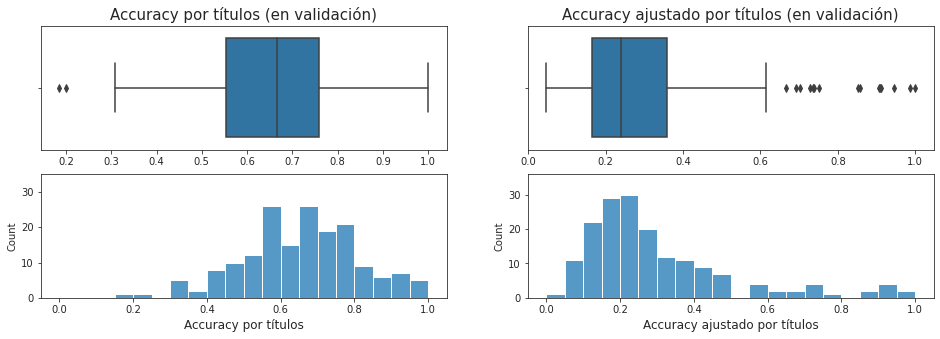

In [73]:
sns.set_style('ticks')

fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2,figsize=(16,5))
font_titles=15
font_labels=12

sns.boxplot(ax=ax1,data=naive_5_05_evalua_accuracy_vld,
            x='accuracy regresor')
ax1.set_title('Accuracy por títulos (en validación)',fontsize=font_titles) 
ax1.set_xlabel('',fontsize=font_labels)

sns.boxplot(ax=ax2,data=naive_5_05_evalua_accuracy_vld,
            x='accuracy ajustado regresor')
ax2.set_title('Accuracy ajustado por títulos (en validación)',fontsize=font_titles)
ax2.set_xlabel('',fontsize=font_labels)

sns.histplot(ax=ax3,data=naive_5_05_evalua_accuracy_vld,
             x='accuracy regresor',
             bins=np.arange(0,1.05,0.05))
ax3.set_xlabel('Accuracy por títulos',fontsize=font_labels)
ax3.set_ylim(0,35)

sns.histplot(ax=ax4,data=naive_5_05_evalua_accuracy_vld,
             x='accuracy ajustado regresor',
             bins=np.arange(0,1.05,0.05))
ax4.set_xlabel('Accuracy ajustado por títulos',fontsize=font_labels)
ax4.set_ylim(0,36)

fig.subplots_adjust(hspace=.2)
plt.show()

In [74]:
# df auxiliar: evita que la leyenda de los hue a continuación sea arbitraria (con 'int') o desordenada:
aux_plot=naive_5_05_evalua_accuracy_vld[['num obs regresor','accuracy regresor',
                                         'accuracy ajustado regresor','num pred por regresor']]
dicc_orden=dict(zip(np.arange(1,10,1),map(lambda num:'0'+str(num),np.arange(1,10,1))))
dicc_orden[10]='10'
aux_plot['num pred por regresor'].replace(dicc_orden,inplace=True)
aux_plot.sort_values(by='num pred por regresor',inplace=True)
lista_ceros=[x for x in dicc_orden.values() if x!='10']
dicc_reverse=dict(zip(lista_ceros,map(lambda x:x[1],lista_ceros)))
aux_plot['num pred por regresor'].replace(dicc_reverse,inplace=True)
aux_plot['num pred por regresor'].unique()

array(['1', '2', '3', '4', '5', '6', '7', '8', '10'], dtype=object)

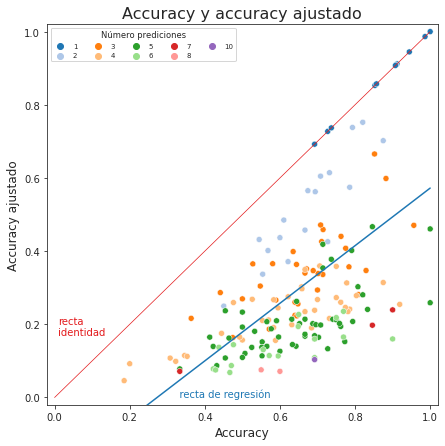

In [75]:
colores=sns.color_palette('Paired')
colores.as_hex()

sns.set_style('ticks')

fig, ax = plt.subplots(1, 1,figsize=(7,7))
font_titles=16
font_labels=12

x=np.arange(0,1,0.001)
plt.plot(x,x,color=colores.as_hex()[5],linewidth=0.7) # recta identidad

sns.regplot(data=aux_plot,
            x='accuracy regresor', 
            y='accuracy ajustado regresor',
            ci=None,scatter=False,line_kws={'linewidth':1.5},color=colores.as_hex()[1]) # recta de regresión

sns.scatterplot(data=aux_plot,
            x='accuracy regresor', 
            y='accuracy ajustado regresor',
            hue='num pred por regresor',palette='tab20')

ax.set_title('Accuracy y accuracy ajustado',fontsize=font_titles) 
ax.set_xlabel('Accuracy',fontsize=font_labels)
ax.set_xlim(-0.02,1.02)
ax.set_ylabel('Accuracy ajustado',fontsize=font_labels)
ax.set_ylim(-0.02,1.02)
ax.legend(title='Número prediciones',ncol=5,fontsize='x-small',title_fontsize='small')
ax.text(x=0.3,y=0,s='    recta de regresión',color=colores.as_hex()[1])
ax.text(x=0.01,y=0.17,s='recta\nidentidad',color=colores.as_hex()[5])

plt.show()

In [76]:
naive_5_05_evalua_accuracy_vld[['accuracy regresor','accuracy ajustado regresor']].corr()

,accuracy regresor,accuracy ajustado regresor
accuracy regresor,1.000000,0.606395
accuracy ajustado regresor,0.606395,1.000000


In [77]:
naive_5_05_evalua_accuracy_vld['mediana posicion acierto por tt'].describe()
# Para más de la mitad del los títulos la mediana de la posición acertada es 1. Y para el 0.75, la posición 
# mediana es la primera o la segunda. 
# La media de la posición mediana es superior a la global: indica que la posición mediana más baja se da con más
# frecuencia en títulos con más observaciones (en la mediana de la mediana por títulos el número de observaciones
# todos los títulos pesan igual con independencia del número de titulados)

count    173.000000
mean       1.540462
std        0.730231
min        1.000000
25%        1.000000
50%        1.000000
75%        2.000000
max        4.000000
Name: mediana posicion acierto por tt, dtype: float64

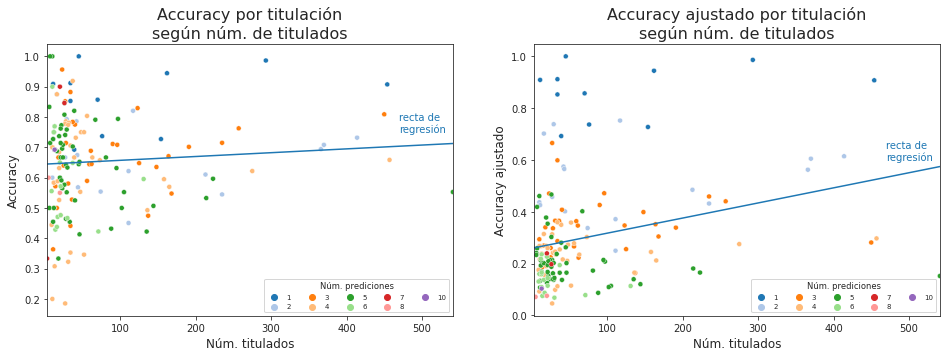

In [78]:
sns.set_style('ticks')

fig, ax = plt.subplots(1, 2,figsize=(16,5))
font_titles=16
font_labels=12

for i,col in enumerate(['accuracy regresor','accuracy ajustado regresor']):
    
    sns.regplot(ax=ax[i],data=aux_plot,
                    x='num obs regresor',
                    y=col,
                    ci=False,scatter=False,line_kws={'linewidth':1.5},color=colores.as_hex()[1])

    sns.scatterplot(ax=ax[i],data=aux_plot,
                    x='num obs regresor',
                    y=col,
                    hue='num pred por regresor',palette='tab20',s=25)
    
    ax[i].set_xlabel('Núm. titulados',fontsize=font_labels)
    ax[i].legend(ncol=5,loc='best',title='Núm. prediciones',fontsize='x-small',title_fontsize='small')
    
    
titulo_0='Accuracy por titulación según núm. de titulados'
ax[0].set_title(textwrap.fill(titulo_0,25),fontsize=font_titles) 
ax[0].set_ylabel('Accuracy',fontsize=font_labels)
ax[0].text(x=470,y=0.75,s='recta de\nregresión',color=colores.as_hex()[1])

titulo_1='Accuracy ajustado por titulación según núm. de titulados'
ax[1].set_title(textwrap.fill(titulo_1,35),fontsize=font_titles) 
ax[1].set_ylabel('Accuracy ajustado',fontsize=font_labels)
ax[1].text(x=470,y=0.6,s='recta de\nregresión',color=colores.as_hex()[1])

fig.subplots_adjust(hspace=.5)
plt.show()

### Observaciones: 

- A mayor número de observaciones para un título, menor número de predicciones para el mismo. Esto indica que cuando aumenta el número de encuestados de una titulación, disminuye el peso individual de las ocupaciones más infrecuentes. Esto hace que las predicciones para el título sean menos (en número) y más sólidas (asociadas a probabilidades más altas).  


- A mayor número de observaciones para un título, mayor accuracy y mayor accuracy ajustado. 

En resumen, las predicciones para los títulos con mayor número de titulados encuestados son menos en número, más sólidas (mayores probabilidades asociadas) y más acertadas en promedio. 

In [80]:
naive_5_05_evalua_accuracy_vld[['num obs regresor','accuracy regresor']].corr()

,num obs regresor,accuracy regresor
num obs regresor,1.000000,0.076986
accuracy regresor,0.076986,1.000000


In [81]:
naive_5_05_evalua_accuracy_vld[['num obs regresor','accuracy ajustado regresor']].corr()

,num obs regresor,accuracy ajustado regresor
num obs regresor,1.000000,0.274887
accuracy ajustado regresor,0.274887,1.000000


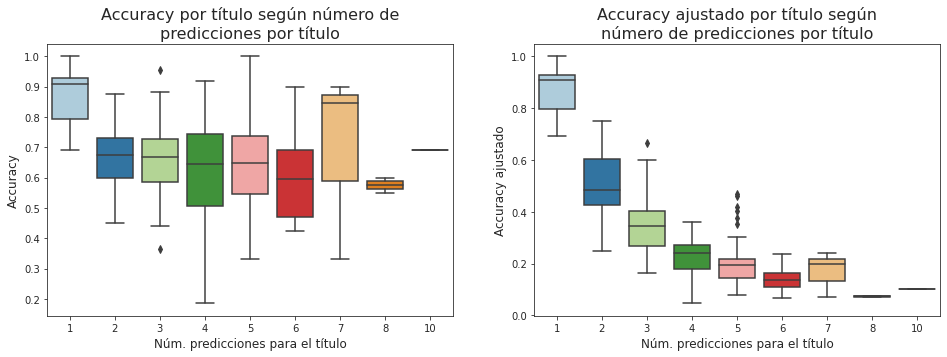

In [82]:
sns.set_style('ticks')

fig, ax= plt.subplots(1, 2,figsize=(16,5))
font_titles=16
font_labels=12

for i,col in enumerate(['accuracy regresor','accuracy ajustado regresor']):
    
    sns.boxplot(ax=ax[i],data=naive_5_05_evalua_accuracy_vld,
                    x='num pred por regresor',
                    y=col,
                    palette='Paired')
    
    ax[i].set_xlabel('Núm. predicciones para el título',fontsize=font_labels)
    ax[i].set_xticklabels(tick for tick in ax[i].get_xticklabels())
    
    
titulo_0='Accuracy por título según número de predicciones por título'
ax[0].set_title(textwrap.fill(titulo_0,35),fontsize=font_titles) 
ax[0].set_ylabel('Accuracy',fontsize=font_labels)

titulo_1='Accuracy ajustado por título según número de predicciones por título'
ax[1].set_title(textwrap.fill(titulo_1,35),fontsize=font_titles) 
ax[1].set_ylabel('Accuracy ajustado',fontsize=font_labels)

fig.subplots_adjust(hspace=.5)
plt.show()

### Observaciones: 

Aumentar el número de predicciones es equivalente a disponer de más intentos para hacer una predicción acertada. Esto aumenta la probabilidad de acertar en alguno de los intentos sin disminuir la tasa de aciertos (accuracy), ya que una predicción se tiene por acertada cuando contiene un elemento acertado, sin que el resto de títulos predichos cuenten como desaciertos.  

Sin embargo, se observa que el accuracy y el accuracy ajustado por título son menores para las titulaciones con mayor número de predicciones (a menos hasta la sexta predicción). Esto se debe a dos causas:    
   
  - Por un lado, el mayor número de predicciones para un título está asociado a un mayor número de ocupaciones relevantes observadas para sus titulados. Esto indica que son títulos para los que la ocupación es más dispersa, ya sea porque lo es en la población (y no solo en la muestra de la encuesta) o porque el título está  poco representado en la muestra, en cuyo caso las ocupaciones infrecuentes individuales están sobrerepresentadas. Esto hace que tanto el accuracy como el accuracy ajustado sean menores para estos títulos. 
  
- Por otro lado, el mayor número de predicciones hace que los aciertos ajustados por la probabilidad tengan menos peso: las probabilidades de cada predicción son menores y los pesos en accuracy ajustado están mas repartidos (recuérdese que estos pesos suman uno). Esto hace que el accuracy ajustado disminuya más deprisa que el accuracy con el número de predicciones. 

En resumen, aunque hacer más predicciones aumenta la tasa global de aciertos (el accuracy global es mayor que el de una regresión logística con una predicción única por título), la tasa de aciertos para los títulos con dos predicciones es menor que para los títulos con una única predicción porque las predicciones únicas corresponden a títulos con ocupaciones más concentradas (más fáciles de predecir correctamente). En otras palabras, los títulos con dos predicciones aportan menos al accuracy global que los títulos con predicción única.  Esto sigue siendo cierto cuando seguimos aumentando el número de predicciones hasta el punto en el que se ofrecen tantas predicciónes (en nuestro caso, 7) que la tasa de aciertos vuelve a incrementarse porque llegan a representar a casi el total de las ocupaciones observadas en train. 

El efecto es más acusado en el accuracy ajustado porque el mayor número de predicciones se penaliza con puntuaciones o pesos más bajos. Tanto es así que el accuracy ajustado (a diferencia del no ajustado) apenas repunta cuando el número de predicciones es excesivo y se acierta por abuso de intentos. 

In [85]:
naive_5_05_evalua_vld['mediana posicion acierto por tt'].describe()

count    11969.000000
mean         1.379439
std          0.587799
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max          4.000000
Name: mediana posicion acierto por tt, dtype: float64

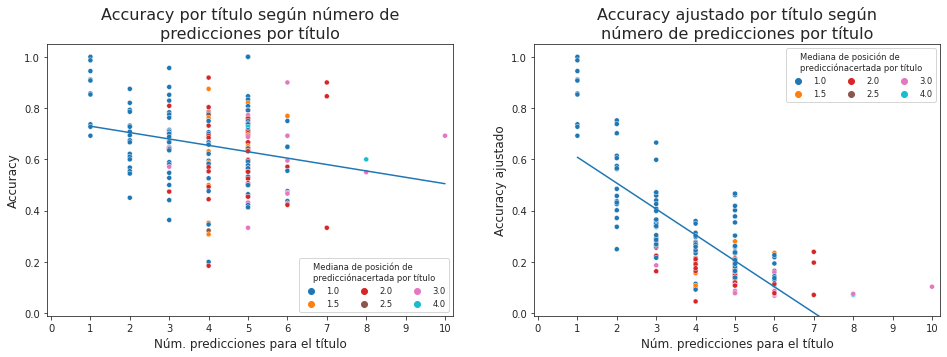

In [146]:
sns.set_style('ticks')

fig, ax = plt.subplots(1, 2,figsize=(16,5))
font_titles=16
font_labels=12

for i,col in enumerate(['accuracy regresor','accuracy ajustado regresor']):
    
    sns.regplot(ax=ax[i],data=naive_5_05_evalua_accuracy_vld,
                x='num pred por regresor',
                y=col,
                ci=False,scatter=False,line_kws={'linewidth':1.5})
    
    sns.scatterplot(ax=ax[i],data=naive_5_05_evalua_accuracy_vld,
                x='num pred por regresor',
                y=col,hue='mediana posicion acierto por tt',
                palette=sns.color_palette('tab10',as_cmap=True),s=25)
    
    ax[i].set_xlabel('Núm. predicciones para el título',fontsize=font_labels)
    ax[i].set_xlim(-0.1,10.2)
    ax[i].set_ylim(-0.01,1.05)
    ax[i].set_xticks(np.arange(0,11,1))

titulo_0='Accuracy por título según número de predicciones por título'
ax[0].set_title(textwrap.fill(titulo_0,35),fontsize=font_titles) 
ax[0].set_ylabel('Accuracy',fontsize=font_labels)
ax[0].legend(title='Mediana de posición de\npredicciónacertada por título',
                 ncol=3,fontsize='small',title_fontsize='small',loc='lower right')

titulo_1='Accuracy ajustado por título según número de predicciones por título'
ax[1].set_title(textwrap.fill(titulo_1,35),fontsize=font_titles) 
ax[1].set_ylabel('Accuracy ajustado',fontsize=font_labels)
ax[1].legend(title='Mediana de posición de\npredicciónacertada por título',
             ncol=3,fontsize='small',title_fontsize='small',loc='upper right')

fig.subplots_adjust(hspace=.5)
plt.show()

### Observaciones: 

- La posición de la prediccion acertada más frecuente es la primera. 

- La posición más frecuente de la predicción acertada según el número de predicciones sigue siendo la primera cuando se hacen 2, 3 o 5 predicciones (**tabla resumen**). 

Esto sugiere que es conveniente reducir el número de predicciones por título del clasificador. Ello tendrá dos efectos claros: 

- Reducirá el accuracy global (menor número de intentos implica menor tasa de aciertos porque las predicciones que acompañan a una predicción acertada no computan como desaciertos). 

- Aumentará la precisión (menor número de predicciones desacertadas). 

El efecto sobre el accuracy ajustado global es incierto. Por un lado, se perderán aciertos, lo que reduce el accuracy ajustado, aunque en menor medida que el no ajustado porque los aciertos que se pierden tenían menos peso. Por otro lado, aumentarán los pesos de las predicciones que se conserven, por lo que, cuando sean acertadas, contribuirán a aumentar el accuracy ajustado. 

In [88]:
naive_5_05_evalua_accuracy_vld[['num pred por regresor','accuracy regresor']].corr()

,num pred por regresor,accuracy regresor
num pred por regresor,1.000000,-0.245921
accuracy regresor,-0.245921,1.000000


In [89]:
naive_5_05_evalua_accuracy_vld[['num pred por regresor','accuracy ajustado regresor']].corr()

,num pred por regresor,accuracy ajustado regresor
num pred por regresor,1.000000,-0.768478
accuracy ajustado regresor,-0.768478,1.000000


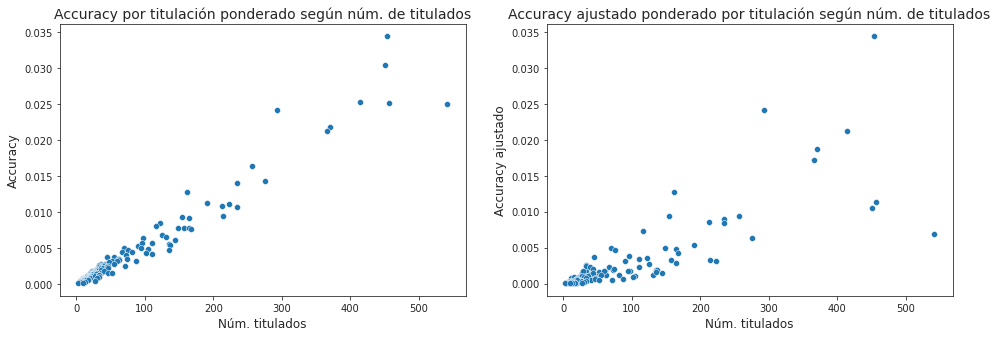

In [90]:
sns.set_style('ticks')

fig, [ax1, ax2] = plt.subplots(1, 2,figsize=(16,5))
font_titles=14
font_labels=12

sns.scatterplot(ax=ax1,data=naive_5_05_evalua_accuracy_vld,
                x='num obs regresor',
                y='accuracy ponderado regresor')
ax1.set_title('Accuracy por titulación ponderado según núm. de titulados',fontsize=font_titles) 
ax1.set_xlabel('Núm. titulados',fontsize=font_labels)
ax1.set_ylabel('Accuracy',fontsize=font_labels)
# hue para num de predicciones 

# Destacar los ac=ac ajustado

sns.scatterplot(ax=ax2,data=naive_5_05_evalua_accuracy_vld,
                x='num obs regresor',
                y='accuracy ajustado ponderado regresor')
ax2.set_title('Accuracy ajustado ponderado por titulación según núm. de titulados',fontsize=font_titles) 
ax2.set_xlabel('Núm. titulados',fontsize=font_labels)
ax2.set_ylabel('Accuracy ajustado',fontsize=font_labels)

fig.subplots_adjust(hspace=.5)
plt.show()

In [91]:
# Accuracy ajustado minora el efecto de ponderación por núm. de titulados: las titulaciones con más peso 
# (más titulados) pesan más en el agregado porque tienen ponderación más fuerte . Esto oculta que pueden 
# tener predicciones menos firmes (más ocupaciones posibles, menos prob). El accuracy ajustado corrige este
# efecto. 
# Naturalmente, el accuracy ponderado es creciente con el núm. de titulados. 
#######################################################Cuidado con el eje y arriba

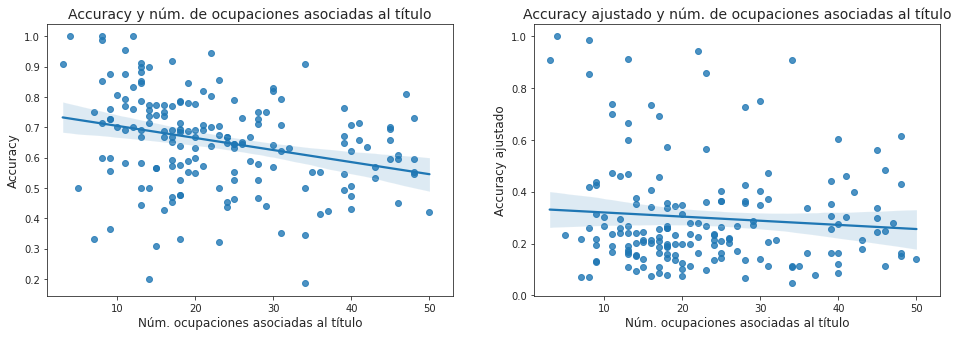

In [92]:
sns.set_style('ticks')

fig, [ax1, ax2] = plt.subplots(1, 2,figsize=(16,5))
font_titles=14
font_labels=12

sns.regplot(ax=ax1,data=naive_5_05_evalua_accuracy_vld,
                x='cat target por regresor (train)',
                y='accuracy regresor')
ax1.set_title('Accuracy y núm. de ocupaciones asociadas al título',fontsize=font_titles) 
ax1.set_xlabel('Núm. ocupaciones asociadas al título',fontsize=font_labels)
ax1.set_ylabel('Accuracy',fontsize=font_labels)
ax1.set_xlim(1,53)

sns.regplot(ax=ax2,data=naive_5_05_evalua_accuracy_vld,
                x='cat target por regresor (train)',
                y='accuracy ajustado regresor')
ax2.set_title('Accuracy ajustado y núm. de ocupaciones asociadas al título',fontsize=font_titles) 
ax2.set_xlabel('Núm. ocupaciones asociadas al título',fontsize=font_labels)
ax2.set_ylabel('Accuracy ajustado',fontsize=font_labels)
ax2.set_xlim(1,53)

fig.subplots_adjust(hspace=.5)
plt.show()

In [93]:
naive_5_05_evalua_accuracy_vld[['cat target por regresor (train)','accuracy regresor']].corr()

,cat target por regresor (train),accuracy regresor
cat target por regresor (train),1.000000,-0.291412
accuracy regresor,-0.291412,1.000000


In [94]:
naive_5_05_evalua_accuracy_vld[['cat target por regresor (train)','accuracy ajustado regresor']].corr()

,cat target por regresor (train),accuracy ajustado regresor
cat target por regresor (train),1.000000,-0.090103
accuracy ajustado regresor,-0.090103,1.000000


# Métricas de evaluación: recall

In [95]:
def naive_evalua_recall(clasificador,data):
    
    evalua=naive_evalua(clasificador=clasificador,data=data)
    
    import re
    lista_re_target=list(filter(lambda col: re.search('.*target.*',col),evalua.columns))
    lista_re_target=list(filter(lambda col: re.search('^(?!.*regresor.*)',col),lista_re_target))
    
    evalua=evalua[lista_re_target].drop_duplicates()
    evalua.set_index(evalua.columns[0],inplace=True)
    evalua.sort_values(by='recall target',ascending=False,inplace=True)

    return evalua

In [96]:
naive_5_05_evalua_recall_vld=naive_evalua_recall(clasificador=naive_5_05_train,data=df_vld)

In [97]:
naive_5_05_evalua_recall_vld.shape, df_vld['ocupacion_'].nunique() # Comprobación

((62, 8), 62)

In [98]:
naive_5_05_evalua_recall_vld.head()

,num obs target,num aciertos por cat target,aciertos ajustados por cat target,recall target,recall ajustado target,peso target,recall ponderado target,recall ajustado ponderado target
target: ocupacion_,,,,,,,,
Prof sanitarios,1494,1398,1294.262592,0.935743,0.866307,0.124822,0.116802,0.108135
"Prof ciencias, matemáticas e ingeniería",1540,1438,908.192595,0.933766,0.589735,0.128666,0.120144,0.075879
Prof enseñanza,1953,1799,1197.750864,0.921147,0.613288,0.163172,0.150305,0.100071
Prof derecho,303,259,152.403482,0.854785,0.502982,0.025315,0.021639,0.012733
Técnicos ciencias e ingenierías,443,361,89.127050,0.814898,0.201190,0.037012,0.030161,0.007446


In [99]:
naive_5_05_evalua_recall_vld.tail()

,num obs target,num aciertos por cat target,aciertos ajustados por cat target,recall target,recall ajustado target,peso target,recall ponderado target,recall ajustado ponderado target
target: ocupacion_,,,,,,,,
Gerentes en servicios excepto hostelería y comercio,34,0,0.0,0.0,0.0,0.002841,0.0,0.0
"Peones de transporte, descargadores y reponedores",28,0,0.0,0.0,0.0,0.002339,0.0,0.0
Trabajadores servicios de cuidados no de salud,58,0,0.0,0.0,0.0,0.004846,0.0,0.0
"Soldadores, chapistas, montadores de estructuras",4,0,0.0,0.0,0.0,0.000334,0.0,0.0
"Mecánicos de precisión, artesanos y artes gráficas",6,0,0.0,0.0,0.0,0.000501,0.0,0.0


In [100]:
#with pd.option_context("display.max_rows", naive_5_05_evalua_recall_vld.shape[0]):
#    display(naive_5_05_evalua_recall_vld)

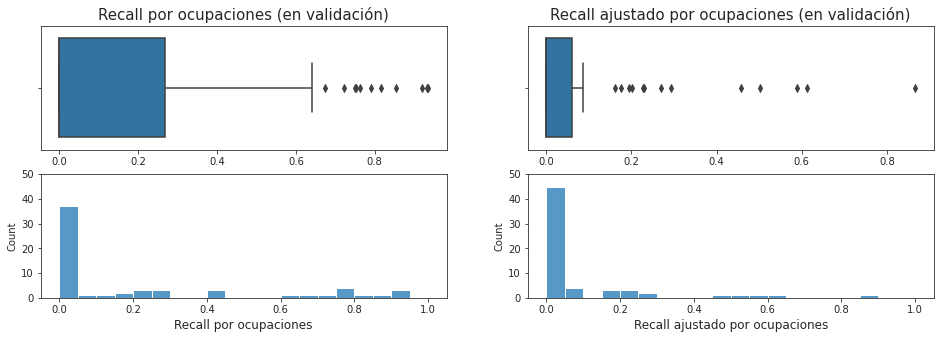

In [101]:
sns.set_style('ticks')

fig, [[ax1, ax2], [ax3, ax4]] = plt.subplots(2, 2,figsize=(16,5))
font_titles=15
font_labels=12

sns.boxplot(ax=ax1,data=naive_5_05_evalua_recall_vld,x='recall target')
ax1.set_title('Recall por ocupaciones (en validación)',fontsize=font_titles) 
ax1.set_xlabel('',fontsize=font_labels)

sns.boxplot(ax=ax2,data=naive_5_05_evalua_recall_vld,x='recall ajustado target')
ax2.set_title('Recall ajustado por ocupaciones (en validación)',fontsize=font_titles)
ax2.set_xlabel('',fontsize=font_labels)

sns.histplot(ax=ax3,data=naive_5_05_evalua_recall_vld,x='recall target',bins=np.arange(0,1.05,0.05))
ax3.set_xlabel('Recall por ocupaciones',fontsize=font_labels)
ax3.set_ylim(0,50)

sns.histplot(ax=ax4,data=naive_5_05_evalua_recall_vld,x='recall ajustado target',bins=np.arange(0,1.05,0.05))
ax4.set_xlabel('Recall ajustado por ocupaciones',fontsize=font_labels)
ax4.set_ylim(0,50)

fig.subplots_adjust(hspace=.2)
plt.show()

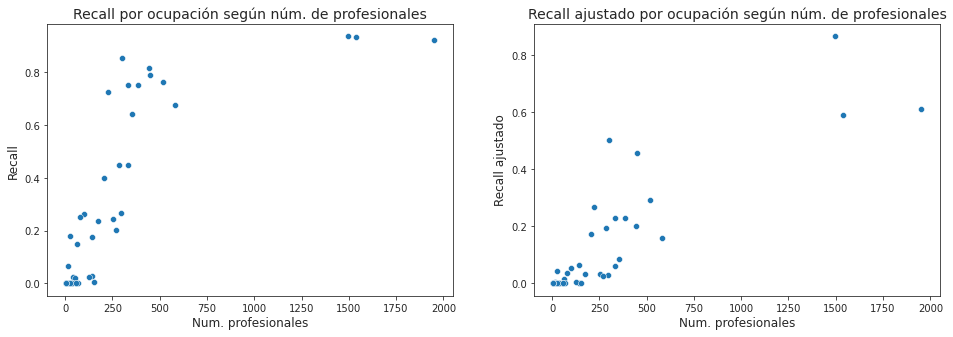

In [102]:
sns.set_style('ticks')

fig, [ax1, ax2] = plt.subplots(1, 2,figsize=(16,5))
font_titles=14
font_labels=12


sns.scatterplot(ax=ax1,data=naive_5_05_evalua_recall_vld,x='num obs target',y='recall target')
ax1.set_title('Recall por ocupación según núm. de profesionales',fontsize=font_titles)
ax1.set_xlabel('Num. profesionales',fontsize=font_labels)
ax1.set_ylabel('Recall',fontsize=font_labels)

sns.scatterplot(ax=ax2,data=naive_5_05_evalua_recall_vld,x='num obs target',y='recall ajustado target')
ax2.set_title('Recall ajustado por ocupación según núm. de profesionales',fontsize=font_titles)
ax2.set_xlabel('Num. profesionales',fontsize=font_labels)
ax2.set_ylabel('Recall ajustado',fontsize=font_labels)

fig.subplots_adjust(hspace=.5)
plt.show()

In [103]:
display(naive_5_05_evalua_recall_vld[['num obs target','recall target']].corr(),
        naive_5_05_evalua_recall_vld[['num obs target','recall ajustado target']].corr())

,num obs target,recall target
num obs target,1.000000,0.782584
recall target,0.782584,1.000000


,num obs target,recall ajustado target
num obs target,1.00000,0.87938
recall ajustado target,0.87938,1.00000


## Conclusiones

###### 1. El rendimiento evaluado por títulos (accuracy) es muy superior al recall evaluado por ocupaciones    

- El dataset es una **encuesta sobre titulados universitarios**: el muestreo está diseñado para garantizar una presencia representativa de los títulos universitarios, no de las ocupaciones profesionales. Los puestos de trabajo que no requieren formación universitaria están infrarepresentados respecto a su peso en la población general.  


###### 2. El accuracy para cada título es poco dependiente del número de egresados de la titulación     

###### 3. El recall por ocupaciones tiene una relación fuerte y directa con el número de profesionales encuestados  

- El **peor rendimiento** se da, sobre todo, en **ocupaciones que no requieren titulación universitaria**: las ocupaciones con **recall nulo** son profesiones no cualificadas u ocupaciones cuya formación especializada es no universitaria, con las excepciones de los profesionales en política y dirección de la Administración Pública y los profesionales de apoyo en finanzas y matemáticas. 
- Las ocupaciones con recall nulo son, también, las más infrarepresentadas en la encuesta. 

# Metricas de evaluación: precisión

In [104]:
# Dataframe para pruebas de función naive_evalua_rhs: 
df_prueba=pd.DataFrame({'titulo_ppal_':['Grado Derecho','Grado Derecho','Grado Derecho',
                                        'Grado Administración y empresa','Grado Medicina'],
                        'ocupacion_':['Prof derecho','Prof derecho',
                                      'Empleados servicios financieros, contables y de apoyo','Prof derecho',
                                      'Prof sanitarios']},
                       index=[50,51,52,53,54])

In [105]:
def naive_evalua_rhs(clasificador, data):
    
    import re
    regresor=list(filter(lambda col: col.startswith('regresor:'),clasificador.columns))[0].split(' ')[1]
    target=list(filter(lambda col: col.startswith('target:'),clasificador.columns))[0].split(' ')[1]
    
    evalua=data[[regresor,target]]
    
    total_obs=evalua.shape[0]
    
    # Num. de observaciones para cada categoría del target (numerador pesos de precisiones ponderadas):
    total_obs_por_cat_target=evalua.groupby(target).agg(['count']) # cuenta sobre target observado
    total_obs_por_cat_target.columns=total_obs_por_cat_target.columns.to_flat_index()
    evalua=evalua.merge(total_obs_por_cat_target,on=target,how='outer') 
    evalua.rename(columns={evalua.columns[-1]:'num obs cat target'},inplace=True)
    
    # Columnas con predicciones (lista targets predichos y lista probabilidades)
    evalua['prediccion']=evalua[regresor]\
                         .apply(lambda valor: naive_predice(clasificador,valor)['prediccion'].tolist())
    evalua['prediccion probs']=evalua[regresor]\
                         .apply(lambda valor: naive_predice(clasificador,valor)['probabilidad'].tolist())
    
    # Columna 'suma de prob. de pred. por regresor' (denominador de acierto ajustado por probabilidad):
    # Se hace aquí para eleminar listas del dataframe (interfieren en comparaciones de filas)
    evalua['suma prob pred por regresor']=evalua['prediccion probs'].apply(lambda lista: sum(lista))
    
    # Núm predicciones:
    evalua['num pred para regresor']=evalua['prediccion'].apply(lambda lista:len(lista))
    max_rank=evalua['num pred para regresor'].max()
    
    for i in range(max_rank):
        # Se sacan las predicciones de la lista y se convierten en columnas:  
        evalua['pred'+str(i)]=evalua['prediccion'][evalua['num pred para regresor']>=i+1]\
                             .apply(lambda lista:lista[i])
        # Se sacan las probabilidades de las predicciones de la lista y se convierten en columnas: 
        evalua['p'+str(i)]=evalua['prediccion probs'][evalua['num pred para regresor']>=i+1]\
                          .apply(lambda lista:lista[i])   

    del evalua['prediccion'], evalua['prediccion probs'] # listas interfieren en comparaciones de filas
    
    # Se odenan todas la predicciones para una observacion (previamente en cols) en filas:
    # Para cada obs., una fila por predicción: filas dénticas salvo por el valor de la predicción y su prob. 
    # Las obs. dejan de corresponderse con filas (varias pred. para una obs.)
    # Las predicciones ordenadas en 2 columnas: predicciones del target y prob. de las predicciones
    
    evalua.rename(columns={'pred0':'predicciones target','p0':'predicciones prob'},inplace=True)
    
    for i in range(1,max_rank):
        aux=evalua[evalua.columns.drop(['predicciones target','predicciones prob'])]
        aux.rename(columns={'pred'+str(i):'predicciones target','p'+str(i):'predicciones prob'},inplace=True)     
        # Prescinde de filas con nan por titulaciones con menos predicciones que otras: 
        aux=aux[aux['predicciones target'].notna()]
        del evalua['pred'+str(i)], evalua['p'+str(i)]
        # Merge conservando índices para identificar observaciones distintas (no se corresponden con filas):
        for df in [evalua,aux]:
            df.reset_index(inplace=True)
        evalua=evalua.merge(aux,how='outer')
        evalua.drop_duplicates(inplace=True)
        evalua.set_index('index',inplace=True)
    
    # Para desligar por índice y asignar valores distintos en col. nuevas para misma obs.: 
    evalua.reset_index(drop=False,inplace=True) 
    evalua.sort_values(by='index',inplace=True)
    
    # Aciertos (binaria):
    evalua['acierto']=0
    evalua['acierto'].mask(evalua['predicciones target']==evalua[target],1,inplace=True)
   
    # Probabilidades de las predicciones acertadas:
    evalua['prob pred acertada']=evalua[evalua['acierto']==1]['predicciones prob']
    
    # Núm. de aciertos (binaria) para cada predicción: 
    aciertos_por_prediccion=evalua[['predicciones target','acierto']].groupby('predicciones target').agg(['sum'])
    aciertos_por_prediccion.columns=aciertos_por_prediccion.columns.to_flat_index()
    evalua=evalua.merge(aciertos_por_prediccion,on='predicciones target')
    evalua.rename(columns={evalua.columns[-1]:'num pred acertadas'},inplace=True)
    
    # Núm. de repeticiones de cada predicción: 
    repeticiones_pred=evalua[['predicciones target','acierto']].groupby('predicciones target').agg(['count'])
    repeticiones_pred.columns=repeticiones_pred.columns.to_flat_index()
    evalua=evalua.merge(repeticiones_pred,on='predicciones target')
    evalua.rename(columns={evalua.columns[-1]:'num pred'},inplace=True)

    # Acierto ajustado: proporción de la probabilidad de predicción acertada sobre suma probs. de predicciones:  
    evalua['acierto ajustado']=evalua[evalua['acierto']==1]['prob pred acertada']\
                              .div(evalua[evalua['acierto']==1]['suma prob pred por regresor'])

    # Suma aciertos ajustados para cada predicción: 
    suma_aciertos_ajustados=evalua[['predicciones target','acierto ajustado']]\
                                           .groupby('predicciones target').agg(['sum'])
    suma_aciertos_ajustados.columns=suma_aciertos_ajustados.columns.to_flat_index()
    evalua=evalua.merge(suma_aciertos_ajustados,on='predicciones target')
    evalua.rename(columns={evalua.columns[-1]:'aciertos ajustados por pred'},inplace=True)
    
    # Precisión y precisión ajustada por predicción: 
    evalua['precision pred']=evalua['num pred acertadas'].div(evalua['num pred'])
    evalua['precision ajustada pred']=evalua['aciertos ajustados por pred']\
                                          .div(evalua['num pred'])
   
    # Pesos de predicciones = num. obs. de target predicho entre total obs.: 
    pesos_pred=evalua[[target,'num obs cat target']]
    pesos_pred['peso pred']=pesos_pred['num obs cat target']/total_obs
    pesos_pred=pesos_pred[[target,'peso pred']]
    pesos_pred.rename(columns={target:'predicciones target'},inplace=True)
    pesos_pred.drop_duplicates(inplace=True)
    evalua=evalua.merge(pesos_pred,on='predicciones target',how='left')
    evalua['peso pred'].fillna(0,inplace=True) # para predicciones no observadas
    
    # Precisión y precisión ajustada ponderada para cada predicción:    
    evalua['precision ponderada pred']=evalua['precision pred']*evalua['peso pred']
    evalua['precision ajustada ponderada pred']=evalua['precision ajustada pred']*evalua['peso pred']
    
    # Formato:
    evalua.set_index('index',inplace=True)
    evalua.sort_index(inplace=True)
    evalua.rename(columns={regresor:'regresor: '+regresor, target:'target: '+target},inplace=True)

    return evalua

In [138]:
prueba=naive_evalua_rhs(clasificador=naive_5_05_train, data=df_prueba)
#prueba

### Evaluación desagregada (en validación) 

In [107]:
naive_5_05_evalua_rhs_vld=naive_evalua_rhs(clasificador=naive_5_05_train, data=df_vld)

In [108]:
naive_5_05_evalua_rhs_vld.head()

,regresor: titulo_ppal_,target: ocupacion_,num obs cat target,suma prob pred por regresor,num pred para regresor,predicciones target,predicciones prob,acierto,prob pred acertada,num pred acertadas,num pred,acierto ajustado,aciertos ajustados por pred,precision pred,precision ajustada pred,peso pred,precision ponderada pred,precision ajustada ponderada pred
index,,,,,,,,,,,,,,,,,,
0,Grado Administración y empresa,Trabajadores protección y seguridad,143,0.611884,5,"Empleados servicios financieros, contables y de apoyo",0.231985,0,NaN,394,2134,NaN,150.875184,0.184630,0.070701,0.043195,0.007975,0.003054
0,Grado Administración y empresa,Trabajadores protección y seguridad,143,0.611884,5,Representantes e intermediarios,0.063211,0,NaN,54,1078,NaN,6.945083,0.050093,0.006443,0.022308,0.001117,0.000144
0,Grado Administración y empresa,Trabajadores protección y seguridad,143,0.611884,5,"Expertos en gestión, finanzas, comercio, etc",0.158028,0,NaN,393,3643,NaN,93.652880,0.107878,0.025708,0.048709,0.005255,0.001252
0,Grado Administración y empresa,Trabajadores protección y seguridad,143,0.611884,5,Empleados administrativos sin atención al público,0.099874,0,NaN,148,2011,NaN,20.412001,0.073595,0.010150,0.027571,0.002029,0.000280
0,Grado Administración y empresa,Trabajadores protección y seguridad,143,0.611884,5,Prof derecho,0.058786,0,NaN,259,1231,NaN,152.403482,0.210398,0.123805,0.025315,0.005326,0.003134


In [109]:
naive_5_05_evalua_rhs_vld['predicciones target'].nunique()
# Núm. de predicciones distintas:

35

In [110]:
naive_5_05_evalua_rhs_vld['target: ocupacion_'].nunique()
# Núm. de ocupaciones distintas observadas: 

62

## Precisión agregada por predicciones

In [111]:
def naive_evalua_precision(clasificador,data):
    
    """
    
    """
    
    evalua=naive_evalua_rhs(clasificador=clasificador,data=data)
    
    import re
    lista_re_pred=list(filter(lambda col: re.search('.*pred.*',col),evalua.columns))
    lista_re_pred=list(filter(lambda col: re.search('^(?!.*regresor.*)',col),lista_re_pred))
    lista_re_pred=list(filter(lambda col: re.search('^(?!.*prob.*)',col),lista_re_pred))
    lista_re_pred=[lista_re_pred[0]]+[lista_re_pred[2]]+[lista_re_pred[1]]+lista_re_pred[3:]
    
    evalua=evalua[lista_re_pred].drop_duplicates()
    
    evalua.set_index('predicciones target',inplace=True)
    evalua.sort_values(by='precision pred',ascending=False,inplace=True)

    return evalua

In [112]:
naive_5_05_precision_vld=naive_evalua_precision(clasificador=naive_5_05_train,data=df_vld)

In [113]:
naive_5_05_precision_vld.shape[0], df_vld['ocupacion_'].nunique() # Comprobación: 
# El núm de ocupaciones predichas es la cuarta parte del núm. de ocupaciones observadas en validación

(35, 62)

In [114]:
naive_5_05_precision_vld

,num pred,num pred acertadas,aciertos ajustados por pred,precision pred,precision ajustada pred,peso pred,precision ponderada pred,precision ajustada ponderada pred
predicciones target,,,,,,,,
Prof sanitarios,2526,1398,1294.262592,0.553444,0.512376,0.124822,0.069082,0.063956
"Prof ciencias, matemáticas e ingeniería",4353,1438,908.192595,0.330347,0.208636,0.128666,0.042504,0.026844
Prof enseñanza,6346,1799,1197.750864,0.283486,0.188741,0.163172,0.046257,0.030797
Prof ciencias sociales,1661,355,205.301230,0.213727,0.123601,0.037514,0.008018,0.004637
Prof derecho,1231,259,152.403482,0.210398,0.123805,0.025315,0.005326,0.003134
Gerentes hostelería y comercio,5,1,0.071429,0.200000,0.014286,0.003258,0.000652,0.000047
Técnicos TI,1275,252,76.374469,0.197647,0.059902,0.027989,0.005532,0.001677
"Empleados servicios financieros, contables y de apoyo",2134,394,150.875184,0.184630,0.070701,0.043195,0.007975,0.003054
Profesionales IT,1687,288,88.332429,0.170717,0.052361,0.032083,0.005477,0.001680


# Resúmenes de métricas de evaluación 

In [115]:
def naive_evalua_criterio_resumen(clasificador,data,criterio):
    """ Función instrumental: generaliza el proceso de resumen de la evaluación de acuerdo con un 'criterio' 
    que se concretará como accuracy, como recall o como precision.
    """
    if criterio=='accuracy':
        evalua=naive_evalua_accuracy(clasificador=clasificador,data=data)
    if criterio=='recall':
        evalua=naive_evalua_recall(clasificador=clasificador,data=data)
    if criterio=='precision':
        evalua=naive_evalua_precision(clasificador=clasificador,data=data)
    
    evalua_resumen=evalua.agg(['sum','mean','median','min','argmin','max','argmax'])
    
    # Ajustes argmin y argmax: 
    for col in evalua.columns: 
        for arg in ['argmin','argmax']:
            indice=int(evalua_resumen.loc[arg,col])
            evalua_resumen.loc[arg,col]=evalua.index[indice]

    return evalua_resumen

In [116]:
def naive_evalua_accuracy_resumen(clasificador,data):
    
    evalua=naive_evalua_criterio_resumen(clasificador=clasificador,data=data,criterio='accuracy')
    
    # Agregados sinsentidos: 
    evalua.loc['sum','accuracy regresor']=''
    evalua.loc['sum','accuracy ajustado regresor']=''
    
    return evalua

In [117]:
def naive_evalua_recall_resumen(clasificador,data):
    
    evalua=naive_evalua_criterio_resumen(clasificador=clasificador,data=data,criterio='recall')
    
    # Agregados sinsentidos: 
    evalua.loc['sum','recall target']=''
    evalua.loc['sum','recall ajustado target']=''
    
    return evalua

In [118]:
def naive_evalua_precision_resumen(clasificador,data):
    
    evalua=naive_evalua_criterio_resumen(clasificador=clasificador,data=data,criterio='precision')
    
    # Agregados sinsentidos: 
    evalua.loc['sum','precision pred']=''
    evalua.loc['sum','precision ajustada pred']=''
    
    return evalua

In [119]:
naive_5_05_evalua_accuracy_resumen_vld=naive_evalua_accuracy_resumen(clasificador=naive_5_05_train,data=df_vld)
naive_5_05_evalua_accuracy_resumen_vld

,num pred por regresor,cat target por regresor (train),num obs regresor,num aciertos por cat regresor,aciertos ajustados por cat regresor,accuracy regresor,accuracy ajustado regresor,peso regresor,accuracy ponderado regresor,accuracy ajustado ponderado regresor,suma prob prediccion,mediana posicion acierto por tt
sum,702,3967,11969,8019,4510.24,,,1,0.669981,0.376826,121.369,266.5
mean,4.0578,22.9306,69.185,46.3526,26.0707,0.653276,0.299402,0.00578035,0.00387272,0.00217819,0.701555,1.54046
median,4,20,30,21,7.63158,0.666667,0.238462,0.00250648,0.00175453,0.000637612,0.696203,1
min,1,3,3,1,0.214286,0.185185,0.046046,0.000250648,8.35492e-05,1.79034e-05,0.40625,1
argmin,Grado Odontología,Máster Odontología,Grado Protocolo y eventos,Grado Protocolo y eventos,Grado Protocolo y eventos,Grado Geografía,Grado Geografía,Grado Protocolo y eventos,Grado Protocolo y eventos,Grado Protocolo y eventos,Grado Política y gestión pública,Grado Odontología
max,10,50,541,412,412,1,1,0.0452001,0.0344223,0.0344223,1,4
argmax,Máster Servicios de transporte,Grado Historia,Grado Administración y empresa,Grado Enfermería,Grado Enfermería,Grado Odontología,Grado Odontología,Grado Administración y empresa,Grado Enfermería,Grado Enfermería,Máster Religión y teología,Máster Estadística


In [120]:
naive_5_05_evalua_recall_resumen_vld=naive_evalua_recall_resumen(clasificador=naive_5_05_train,data=df_vld)
naive_5_05_evalua_recall_resumen_vld

,num obs target,num aciertos por cat target,aciertos ajustados por cat target,recall target,recall ajustado target,peso target,recall ponderado target,recall ajustado ponderado target
sum,11969,8019,4510.24,,,1,0.669981,0.376826
mean,193.048,129.339,72.7457,0.209503,0.0851357,0.016129,0.0108061,0.00607785
median,38.5,0,0,0,0,0.00321664,0,0
min,2,0,0,0,0,0.000167098,0,0
argmin,"Trabajadores cualif act forestales, pesqueras, cinegéticas",Operadores de instalaciones y maquinaria fija,Operadores de instalaciones y maquinaria fija,Operadores de instalaciones y maquinaria fija,Operadores de instalaciones y maquinaria fija,"Trabajadores cualif act forestales, pesqueras, cinegéticas",Operadores de instalaciones y maquinaria fija,Operadores de instalaciones y maquinaria fija
max,1953,1799,1294.26,0.935743,0.866307,0.163172,0.150305,0.108135
argmax,Prof enseñanza,Prof enseñanza,Prof sanitarios,Prof sanitarios,Prof sanitarios,Prof enseñanza,Prof enseñanza,Prof sanitarios


In [121]:
naive_5_05_evalua_precision_resumen_vld=naive_evalua_precision_resumen(clasificador=naive_5_05_train,data=df_vld)
naive_5_05_evalua_precision_resumen_vld
# suma pesos pred != 1 : pesos de predicciones imputados por pesos observaciones

,num pred,num pred acertadas,aciertos ajustados por pred,precision pred,precision ajustada pred,peso pred,precision ponderada pred,precision ajustada ponderada pred
sum,40529,8019,4510.24,,,0.962152,0.223981,0.144467
mean,1157.97,229.114,128.864,0.115935,0.0511079,0.0274901,0.00639947,0.00412762
median,582,54,7.89235,0.0817791,0.0110874,0.0172947,0.00126304,0.000176449
min,3,0,0,0,0,0.000167098,0,0
argmin,Política y dirección Admón Pública,"Trabajadores cualif act forestales, pesqueras, cinegéticas","Trabajadores cualif act forestales, pesqueras, cinegéticas","Trabajadores cualif act forestales, pesqueras, cinegéticas","Trabajadores cualif act forestales, pesqueras, cinegéticas","Trabajadores cualif act forestales, pesqueras, cinegéticas","Trabajadores cualif act forestales, pesqueras, cinegéticas","Trabajadores cualif act forestales, pesqueras, cinegéticas"
max,6346,1799,1294.26,0.553444,0.512376,0.163172,0.0690823,0.0639561
argmax,Prof enseñanza,Prof enseñanza,Prof sanitarios,Prof sanitarios,Prof sanitarios,Prof enseñanza,Prof sanitarios,Prof sanitarios


# Evaluación: agregados 

In [122]:
def naive_evalua_regresor(clasificador,data):
    
    """Resume las métricas relacionadas con el accuracy para cada categoría del regresor a partir del clasificador
    entrenado y el set de datos de evaluación. 
    """
    
    import re
    
    resumen=naive_evalua_accuracy(clasificador=clasificador,data=data)
    lista_re_accuracy_1=list(filter(lambda col: re.search('.*accuracy.*',col),resumen.columns))
    lista_re_accuracy_2=list(filter(lambda col: re.search('.*peso.*',col),resumen.columns))
    resumen=resumen[lista_re_accuracy_1+lista_re_accuracy_2]
    resumen.index.rename('regresor',inplace=True)

    # Formato: 
    columnas=[resumen.columns[-1]]+resumen.columns[:-1].tolist()
    resumen=resumen[columnas]
    dicc_col=dict(zip(resumen.columns,list(map(lambda col: col.rsplit(' ',1)[0],resumen.columns))))
    resumen.rename(columns=dicc_col,inplace=True)
    resumen.sort_values(by='accuracy',ascending=False,inplace=True)

    return resumen

In [123]:
naive_5_05_regresor=naive_evalua_regresor(clasificador=naive_5_05_train,data=df_vld)

In [124]:
naive_5_05_regresor.sum()

peso                             1.000000
accuracy                       113.016677
accuracy ajustado               51.796596
accuracy ponderado               0.669981
accuracy ajustado ponderado      0.376826
dtype: float64

In [125]:
naive_5_05_regresor.head()

,peso,accuracy,accuracy ajustado,accuracy ponderado,accuracy ajustado ponderado
regresor,,,,,
Grado Odontología,0.003760,1.000000,1.000000,0.003760,0.003760
"Máster Ciencias químicas, físicas y geológicas; Matemáticas y estadística (Otros estudios)",0.000585,1.000000,0.258929,0.000585,0.000151
Grado Literatura,0.000835,1.000000,0.460714,0.000835,0.000385
Grado Medicina,0.024480,0.986348,0.986348,0.024146,0.024146
Máster Música y artes del espectáculo,0.001922,0.956522,0.470531,0.001838,0.000904


In [126]:
def naive_evalua_target(clasificador,data):
    
    """Resume las métricas relacionadas con la precisión y el recall para cada categoría del target a partir 
    del clasificador entrenado y el set de datos de evaluación. 
    """
    
    import re
    
    resumen_precision=naive_evalua_precision(clasificador=clasificador,data=data)
    lista_re_precision=list(filter(lambda col: re.search('.*precision.*',col),resumen_precision.columns))
    resumen_precision=resumen_precision[lista_re_precision]
    resumen_precision.index.rename('target',inplace=True)
    
    resumen_recall=naive_evalua_recall(clasificador=clasificador,data=data)
    lista_re_recall_1=list(filter(lambda col: re.search('.*recall.*',col),resumen_recall.columns))
    lista_re_recall_2=list(filter(lambda col: re.search('.*num.*',col),resumen_recall.columns)) 
    lista_re_recall_3=list(filter(lambda col: re.search('.*peso.*',col),resumen_recall.columns))
    resumen_recall=resumen_recall[lista_re_recall_1+lista_re_recall_2+lista_re_recall_3]
    resumen_recall.index.rename('target',inplace=True)
    
    resumen=resumen_precision.merge(resumen_recall,left_index=True,right_index=True,how='outer')

    # Formato: 
    columnas=resumen.columns[-3:].tolist()+resumen.columns[:-3].tolist()
    resumen=resumen[columnas]
    dicc_col=dict(zip(resumen.columns,list(map(lambda col: col.rsplit(' ',1)[0],resumen.columns))))
    dicc_col=dict(zip(dicc_col.keys(),list(map(lambda col: col.split('por')[0],dicc_col.values()))))
    resumen.rename(columns=dicc_col,inplace=True)
    resumen.sort_values(by=['num obs','precision','recall'],ascending=False,inplace=True)
    
    resumen['indice f1']=2*resumen['precision']*resumen['recall']/(resumen['precision']+resumen['recall'])
    resumen['indice f1 ajustado']=2*resumen['precision ajustada']*resumen['recall ajustado']\
                                  /(resumen['precision ajustada']+resumen['recall ajustado'])
    resumen['indice f1 ponderado']=resumen['indice f1']*resumen['peso']
    resumen['indice f1 ajustado ponderado']=resumen['indice f1 ajustado']*resumen['peso']

    return resumen

In [127]:
prueba=naive_evalua_target(clasificador=naive_5_05_train,data=df_prueba)
prueba

,num obs,num aciertos,peso,precision,precision ajustada,precision ponderada,precision ajustada ponderada,recall,recall ajustado,recall ponderado,recall ajustado ponderado,indice f1,indice f1 ajustado,indice f1 ponderado,indice f1 ajustado ponderado
target,,,,,,,,,,,,,,,
Prof derecho,3.0,3.0,0.6,0.75,0.353916,0.45,0.212349,1.0,0.471887,0.6,0.283132,0.857143,0.404475,0.514286,0.242685
Prof sanitarios,1.0,1.0,0.2,1.00,1.000000,0.20,0.200000,1.0,1.000000,0.2,0.200000,1.000000,1.000000,0.200000,0.200000
"Empleados servicios financieros, contables y de apoyo",1.0,1.0,0.2,0.25,0.031501,0.05,0.006300,1.0,0.126002,0.2,0.025200,0.400000,0.050401,0.080000,0.010080
Empleados administrativos sin atención al público,NaN,NaN,NaN,0.00,0.000000,0.00,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"Expertos en gestión, finanzas, comercio, etc",NaN,NaN,NaN,0.00,0.000000,0.00,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Representantes e intermediarios,NaN,NaN,NaN,0.00,0.000000,0.00,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [128]:
naive_5_05_target=naive_evalua_target(clasificador=naive_5_05_train,data=df_vld)

In [129]:
naive_5_05_target.sum()

num obs                         11969.000000
num aciertos                     8019.000000
peso                                1.000000
precision                           4.057731
precision ajustada                  1.788777
precision ponderada                 0.223981
precision ajustada ponderada        0.144467
recall                             12.989166
recall ajustado                     5.278416
recall ponderado                    0.669981
recall ajustado ponderado           0.376826
indice f1                           5.756037
indice f1 ajustado                  2.568036
indice f1 ponderado                 0.324613
indice f1 ajustado ponderado        0.203177
dtype: float64

In [130]:
naive_5_05_target.head()

,num obs,num aciertos,peso,precision,precision ajustada,precision ponderada,precision ajustada ponderada,recall,recall ajustado,recall ponderado,recall ajustado ponderado,indice f1,indice f1 ajustado,indice f1 ponderado,indice f1 ajustado ponderado
target,,,,,,,,,,,,,,,
Prof enseñanza,1953,1799,0.163172,0.283486,0.188741,0.046257,0.030797,0.921147,0.613288,0.150305,0.100071,0.433546,0.288649,0.070742,0.047099
"Prof ciencias, matemáticas e ingeniería",1540,1438,0.128666,0.330347,0.208636,0.042504,0.026844,0.933766,0.589735,0.120144,0.075879,0.488037,0.308228,0.062794,0.039658
Prof sanitarios,1494,1398,0.124822,0.553444,0.512376,0.069082,0.063956,0.935743,0.866307,0.116802,0.108135,0.695522,0.643912,0.086817,0.080375
"Expertos en gestión, finanzas, comercio, etc",583,393,0.048709,0.107878,0.025708,0.005255,0.001252,0.674099,0.160640,0.032835,0.007825,0.185991,0.044322,0.009059,0.002159
"Empleados servicios financieros, contables y de apoyo",517,394,0.043195,0.184630,0.070701,0.007975,0.003054,0.762089,0.291828,0.032918,0.012605,0.297246,0.113825,0.012840,0.004917


In [131]:
def naive_evalua_resumen(clasificador, data, nombre='naive'):
    
    resumen=naive_evalua_target(clasificador=clasificador, data=data)
    resumen=resumen[['precision ponderada', 'precision ajustada ponderada','recall ponderado',
                   'recall ajustado ponderado','indice f1 ponderado','indice f1 ajustado ponderado']]
    dicc_col=dict(zip(resumen.columns,map(lambda col: col.rsplit(' ',1)[0],resumen.columns)))
    resumen.rename(columns=dicc_col,inplace=True)
    resumen.rename(columns={'recall':'recall (o accuracy)'},inplace=True)
    
    resumen=pd.DataFrame(resumen.sum())
    resumen.rename(columns={resumen.columns[0]:str(nombre)},inplace=True)
    resumen.index.rename('medias ponderadas',inplace=True)
    
    return resumen

In [132]:
prueba=naive_evalua_resumen(clasificador=naive_5_05_train,data=df_prueba)
prueba

,naive
medias ponderadas,
precision,0.700000
precision ajustada,0.418649
recall (o accuracy),1.000000
recall ajustado,0.508333
indice f1,0.794286
indice f1 ajustado,0.452765


In [133]:
naive_5_05_resumen=naive_evalua_resumen(clasificador=naive_5_05_train,data=df_vld)

In [134]:
naive_5_05_resumen

,naive
medias ponderadas,
precision,0.223981
precision ajustada,0.144467
recall (o accuracy),0.669981
recall ajustado,0.376826
indice f1,0.324613
indice f1 ajustado,0.203177


In [135]:
naive_encuesta=naive_fit(data=df,regresor='titulo_ppal_',target='ocupacion_',max_rank=5,min_prop=0.05)

In [136]:
def naive_comparador(lista_clasificadores,lista_data):
    
    m=len(lista_clasificadores)
    if type(lista_data)!=list: 
        lista_data=[lista_data]*m
    resumen=naive_evalua_resumen(clasificador=lista_clasificadores[0], data=lista_data[0])
    #resumen.rename
    for i in range(1,m):
        evalua=naive_evalua_resumen(clasificador=lista_clasificadores[i], data=lista_data[i])
        resumen=pd.concat([resumen,evalua],axis=1)
        
    return resumen

In [137]:
prueba=naive_comparador([naive_5_05_train,naive_5_05_train],[df_prueba, df_prueba.sample(3)])
prueba

,naive,naive
medias ponderadas,,
precision,0.700000,1.000000
precision ajustada,0.418649,0.773196
recall (o accuracy),1.000000,1.000000
recall ajustado,0.508333,0.773196
indice f1,0.794286,1.000000
indice f1 ajustado,0.452765,0.773196
